# Synthetic Dataset with Correlated Features



In [13]:
#!pip install timesynth
# TIMESYNTH TO GENERATE TIME SERIESES
import ts_syntheticData
from ts_syntheticData import insert_anomalies
# CUSTOM DEFINED DATALOADERS AND MODELS
from ts_dataloader import get_datasets, load_data
from ts_training import train_network
from ts_VI_LSTM import Variational_LSTM, loss_normal2d
from ts_simple_LSTM_net import Standard_LSTM, loss_function_normal
from ts_anomaly_function import detect_anomalies, detect_anomalies_VAE
# PYTORCH
import torch
from torch import optim, distributions
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
# MATPLOTLIB NUMPY
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import numpy as np


In [14]:
def plot_anomalies(anomaly_data, sequence, A=0, B=1000):

    labels = anomaly_data["outlier_label"]
    if sequence.shape[0] != len(labels):
        raise ValueError("The length of the sequence and the number of labels whould be the same.")
    
    Ti = max(0, A)
    Tf = min(B, sequence.shape[0])
    time_axis = list(range(Ti,Tf-1))
    
    figures= []
    for dimension in range(sequence.shape[1]):

        fig = plt.figure(figsize = (15,5))
        plt.title("Feature {}".format(dimension))
        for t in range(Ti, Tf-1):
            plt.plot(t, sequence[t, dimension], 'o', color="red" if labels[t] else "blue", markersize = 6 if labels[t] else 2)
        plt.plot(time_axis, sequence[Ti:Tf-1,dimension], label = "Real data")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.legend()
        figures.append(fig)
        plt.show()
    
    return figures

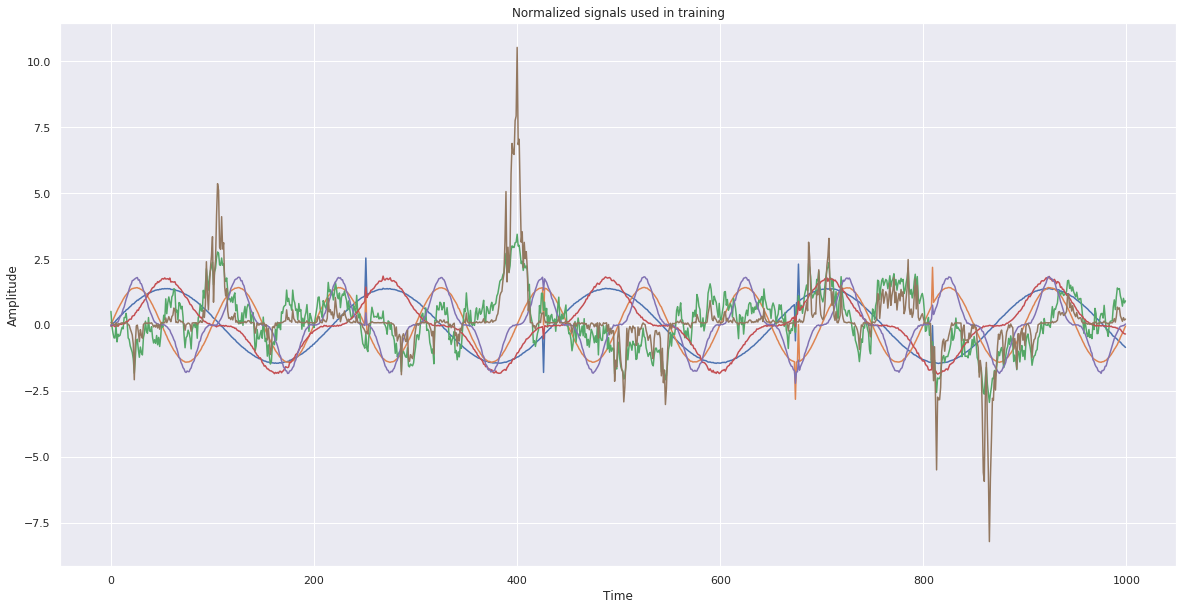

In [16]:
#USEDATASET = 0  # simple synthetic dataset
USEDATASET = 1 # correlated synthetic dataset
#USEDATASET = 2 # realistic weather dataset

# anomaly parameters
add_anomalies = False
if (USEDATASET == 0) or (USEDATASET == 1):
    add_anomalies = True
# anomaly probability
anomalies_p = 0.005
# anomaly magnitude
anomalies_m = 2


# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

# number of samples in the time series
train_T = 1000
valid_T = 1000
test_T = 500
# width of the window of each time series
W = 1000
# check for inconsistency
if W > train_T:
    raise ValueError("The time window cannot be longer than the training data sequence available.")

T = train_T + valid_T + test_T
# the size of train and validation, test is the remainder of the data
t_v_t_split = [train_T/T,valid_T/T]

#load the data in, this is supposed to happen only once
raw_signals = load_data(USEDATASET, T)

if add_anomalies:
    timeseries_signals, timeseries_labels = insert_anomalies(raw_signals, magnitude=anomalies_m, p=anomalies_p)
else:
    timeseries_signals = raw_signals
    timeseries_labels = None

features, train_dataset, valid_dataset, test_dataset = get_datasets(USEDATASET, t_v_t_split, W, device, timeseries_signals, timeseries_labels)

train_timeseries_signals = train_dataset.get_data()[0]
plt.figure(figsize = (20,10))
plt.title("Normalized signals used in training")
plt.plot(list(range(len(train_timeseries_signals))), train_timeseries_signals)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [17]:
device

device(type='cuda', index=0)

In [18]:
# Here we can change to batch size
# batch size (number of serieses of length W)
B = 1
# check for consistency, we don't want to pad the sequence if possible
if (train_T - W + 1) % B != 0 :
    raise ValueError("The batch size chosen will result in different sized batches during training")

# create the Synthetic Dataset
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=False)
#valid_loader = DataLoader(valid_dataset, shuffle=False)
#seq_loader = DataLoader(valid_dataset, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

## Baseline LSTM model

We use a straightforward approach. An LSTM with 2 layers, followed by 2 linear layers. This structure was thought initially so that a high degree of non-linearities are present in the model to accomodate for the complicated features that are present in the dataset. 

The complexity introduced is arguably necessary, however, poorer results were achieved when reducing the number of neurons and layers.

The loss function is the one explained in the report. We use the entire train time series to train the network in one pass. This improves speed of training drammatically.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as distributions


# x[batch_size, num_features]
class Standard_LSTM(nn.Module):
    def __init__(self, input_dimension, param_size, hidden_dim):
        super(Standard_LSTM, self).__init__()

        self.input_dimension = input_dimension
        self.hidden_dim = hidden_dim
        self.param_size = param_size

        # define the LSTM
        self.lstm = nn.LSTM(input_dimension, hidden_dim, num_layers=2)
        # linear mapping
        self.hidden2hidden = nn.Linear(hidden_dim, hidden_dim)
        # relu activation
        self.relu = nn.ReLU()
        # maping to parameters for distribution of signal
        self.hidden2params = nn.Linear(hidden_dim, param_size * input_dimension)

    def forward(self, x, device):
        outputs = {}
        outputs["x_input"] = x
        x = x.permute(1, 0, 2)
        # lstm_out is the output of the last layer of hidden units [seq_len, batch, num_directions * hidden_size]
        # h is the hidden states at the last time step
        # c is the cell state at the last time step
        lstm_out, (h, c) = self.lstm(x)
        # linear wants [batch, seq_len, hidden_size]
        # lstm_out = lstm_out.permute(1, 0, 2)
        linear_in = self.dropout(self.relu(self.hidden2hidden(lstm_out)))

        # take output of hidden layers at each time step h_t and run it through a fully connected layer
        params = self.hidden2params(linear_in)

        outputs["params"] = params
        outputs["param_size"] = self.param_size
        return outputs


def loss_function_normal(model_output, device):
    # unpack the required quantities
    x_true = model_output["x_input"].permute(1, 0, 2)

    input_dimension = x_true.shape[2]

    # check to see if something went wrong with selecting the right loss function and network pair
    if model_output["params"].shape[2] != 2 * input_dimension:
        raise ValueError("Wrong input dimensions or number of parameters in the output")

    # extrapolate parameters
    mu, log_var = torch.chunk(model_output["params"], 2, dim=2)
    sigma = torch.exp(log_var / 2)
    #print(mu.shape)
    #get the length of the sequence
    seq_length = mu.shape[0]
    # iterate over each time step in the sequence to compute NLL
    t = 0
    #cov_matrix = torch.diag_embed(sigma[:, t, :])
    # define the distribution
    p = distributions.Normal(mu[t, :, :], sigma[t, :, :])
    log_prob = torch.mean(p.log_prob(x_true[t + 1, :, :]), dim=-1)

    for t in range(1, seq_length - 1):
        # print(t)
        # construct (diagonal) covariance matrix for each time step based on
        # the estimated var from the model
        #cov_matrix = torch.diag_embed(sigma[:, t, :])

        # define the distribution
        p = distributions.Normal(mu[t, :, :], sigma[t, :, :])

        log_prob += torch.mean(p.log_prob(x_true[t + 1, :, :]), dim=-1)
        # print(x_true.shape)

    NLL = - torch.mean(log_prob, dim=0) / seq_length
    return {
        "loss": NLL,
        "NLL": NLL
    }


Training has started.
Epoch: 0


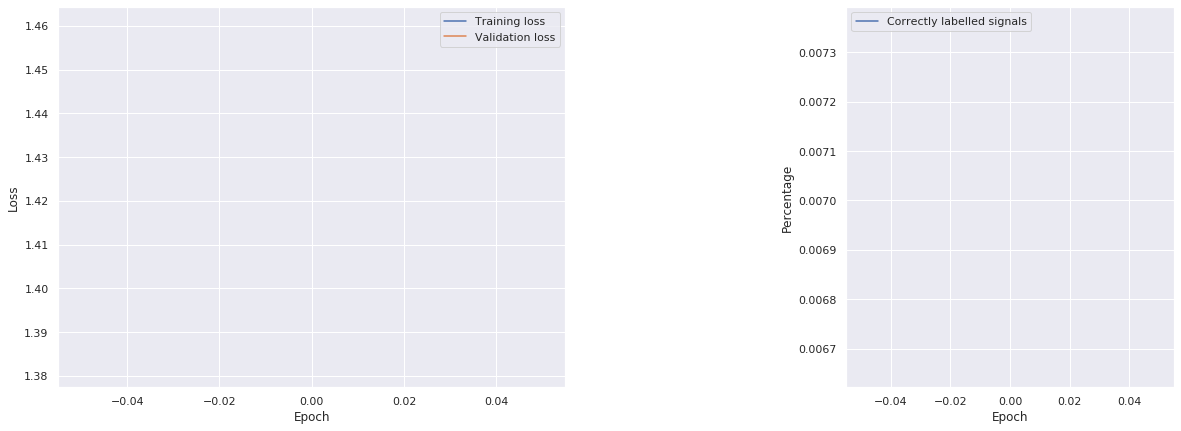

Epoch: 9


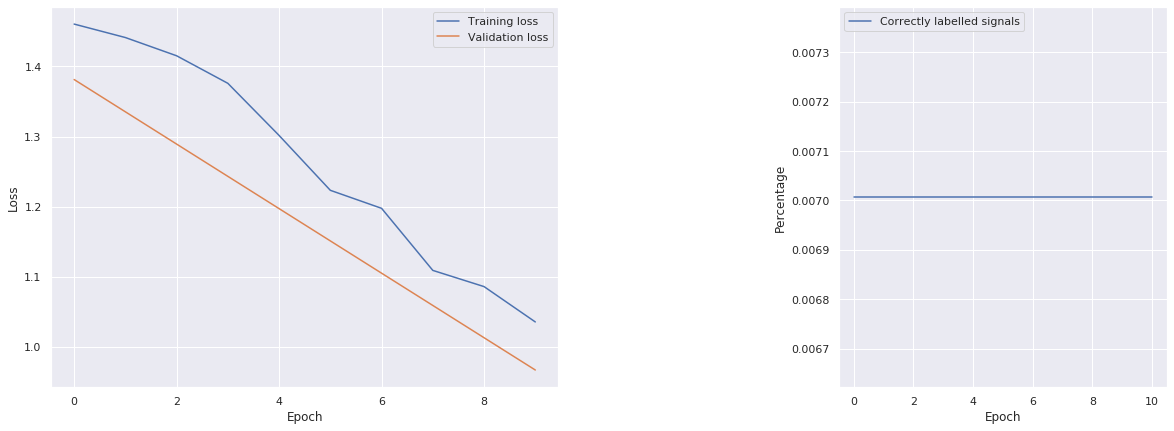

Epoch: 19


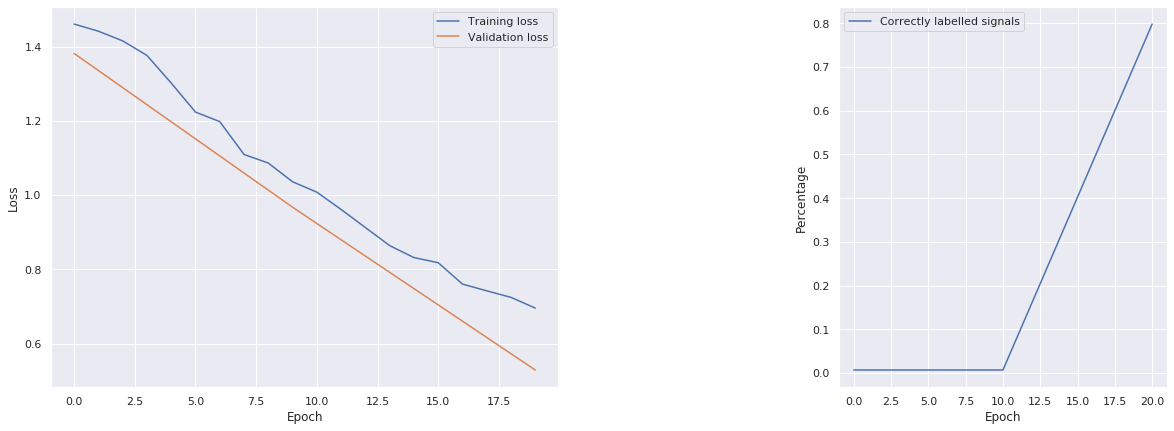

Epoch: 29


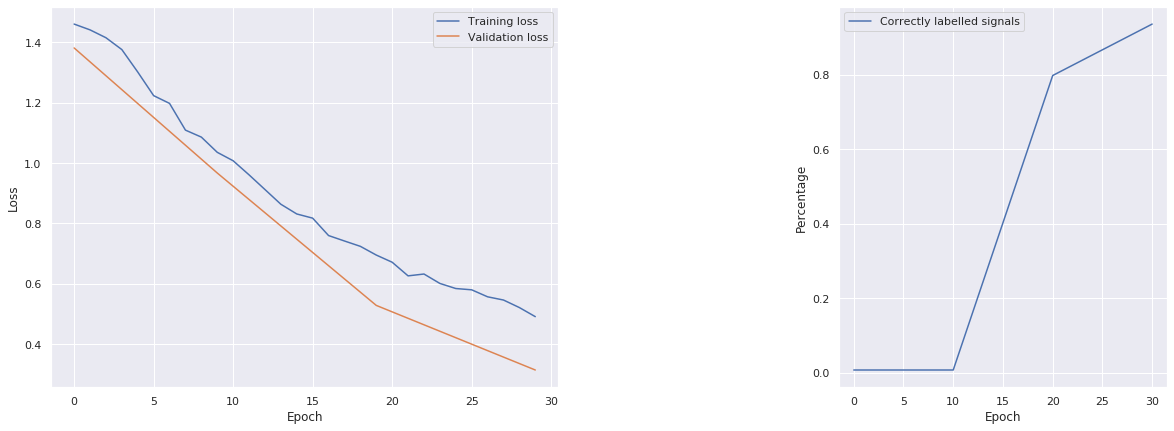

Epoch: 39


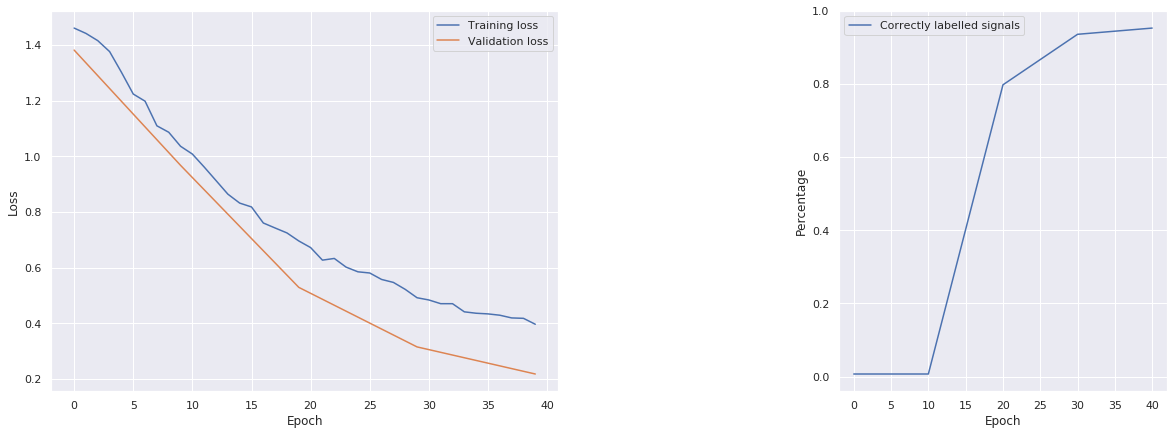

Epoch: 49


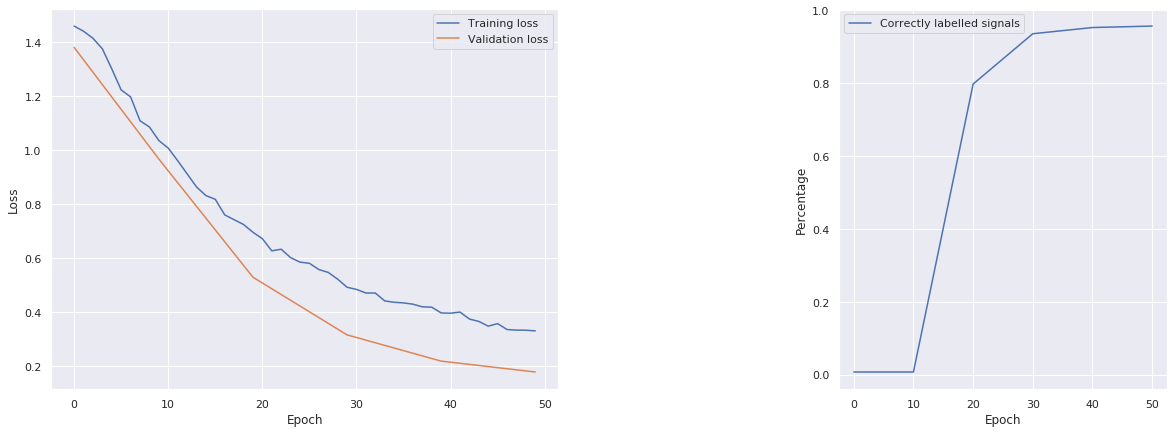

Epoch: 59


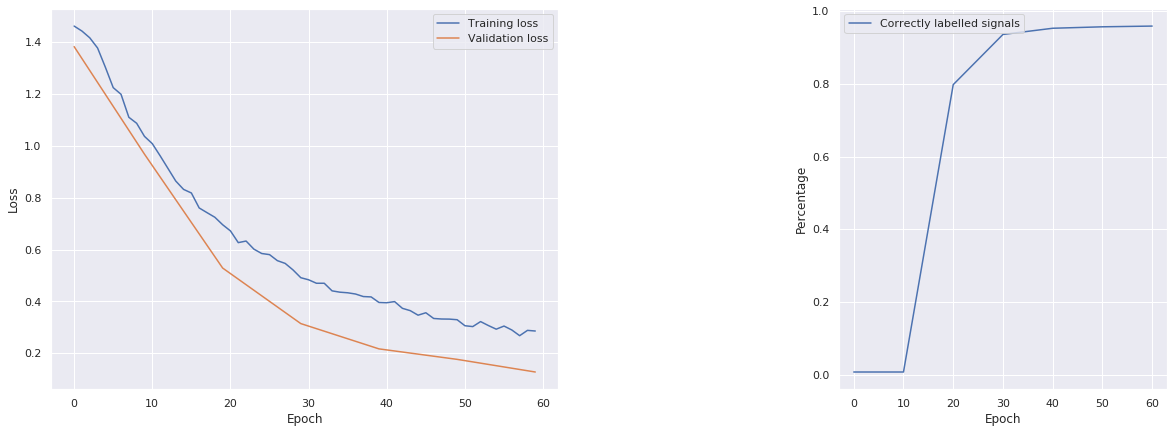

Epoch: 69


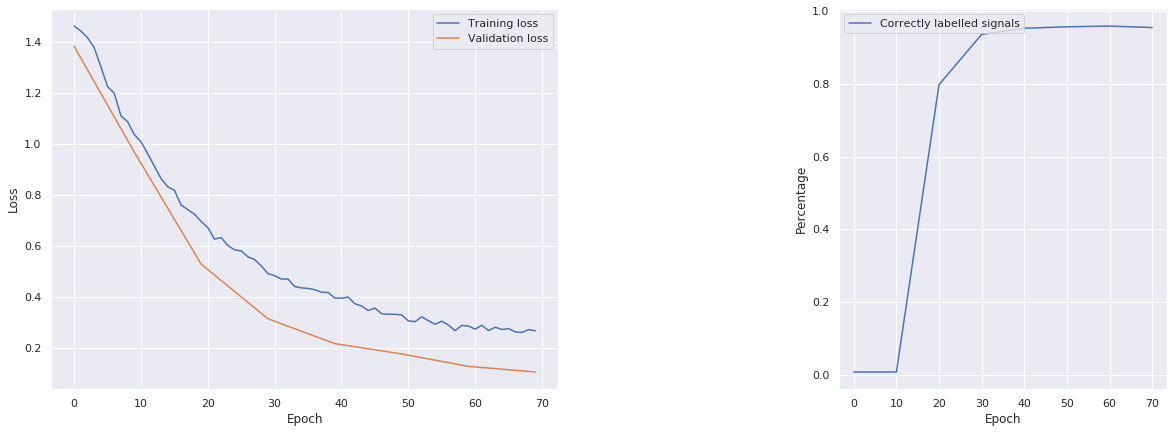

Epoch: 79


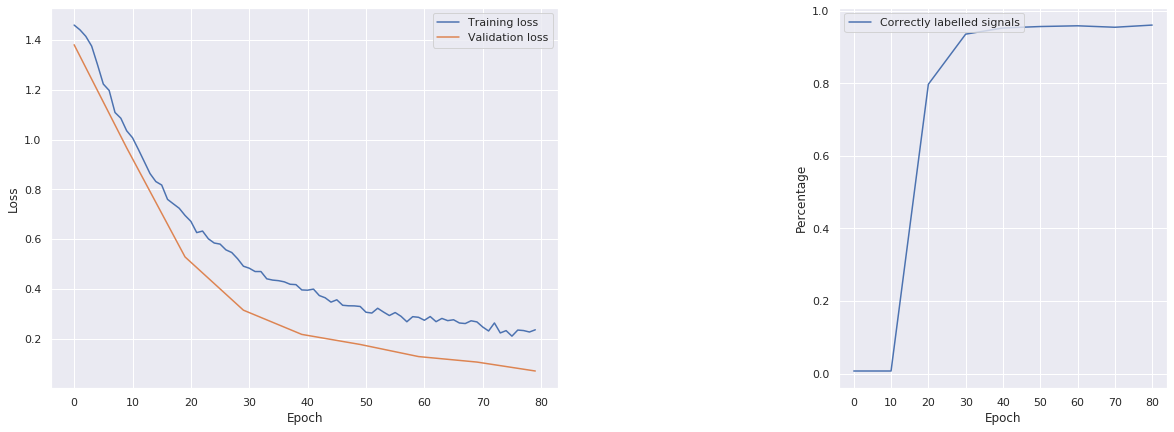

Epoch: 89


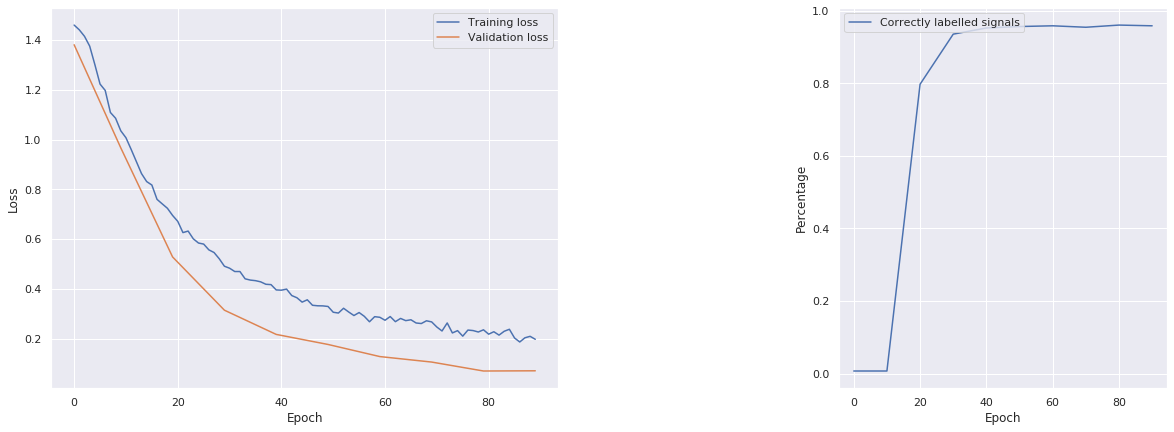

Epoch: 99


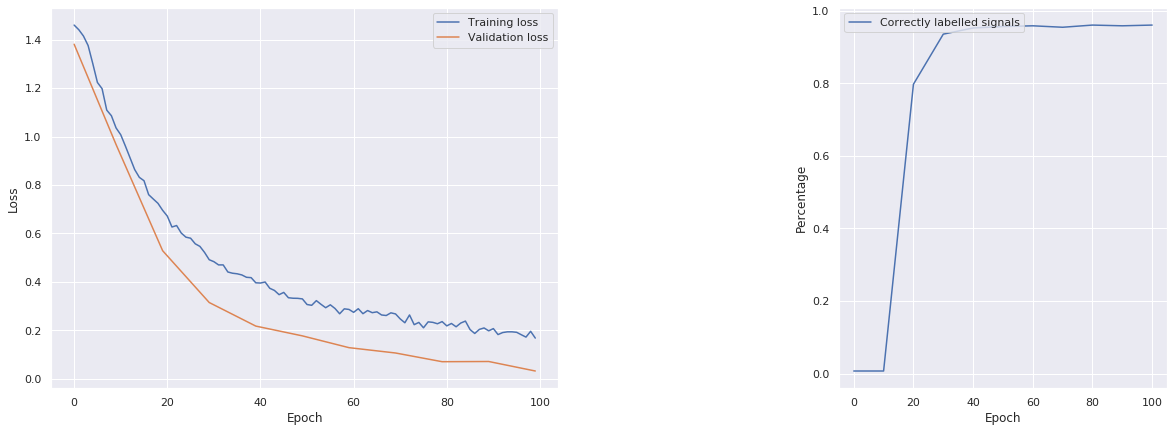

Epoch: 109


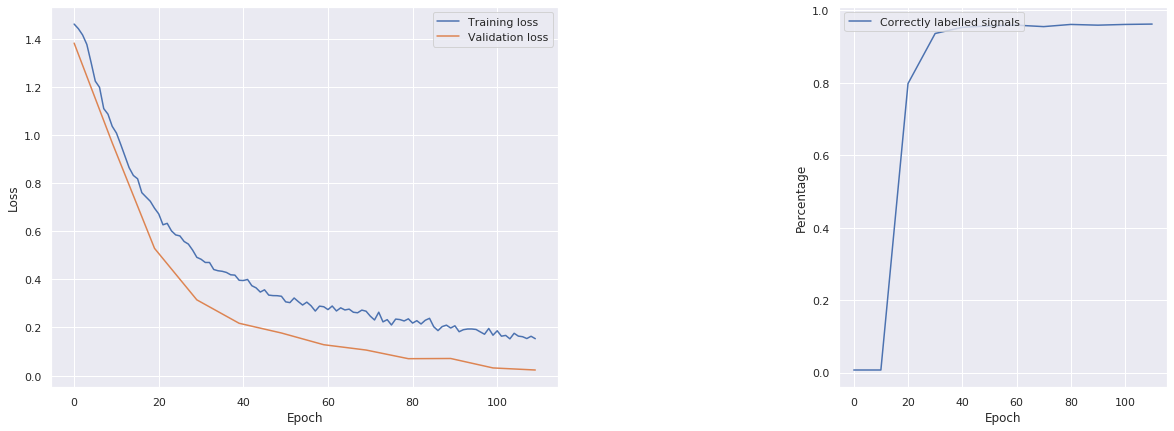

Epoch: 119


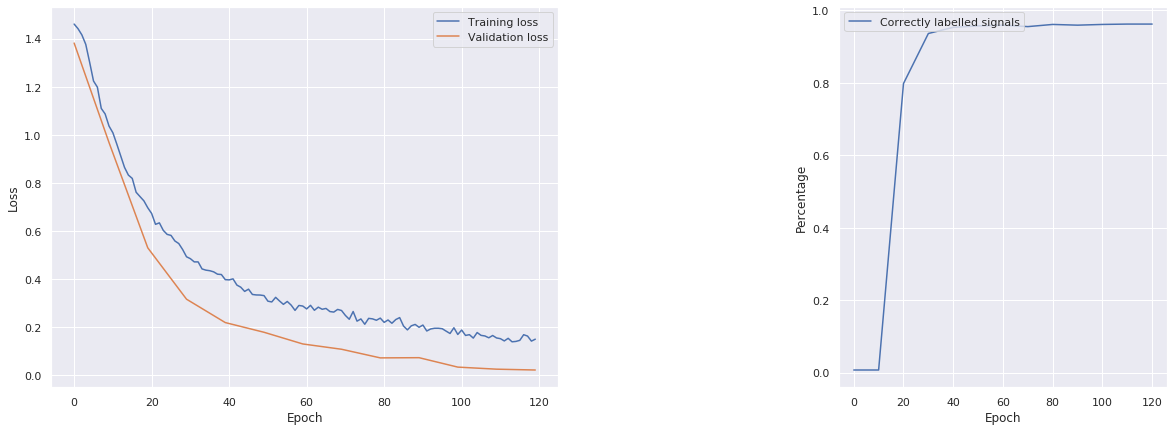

Epoch: 129


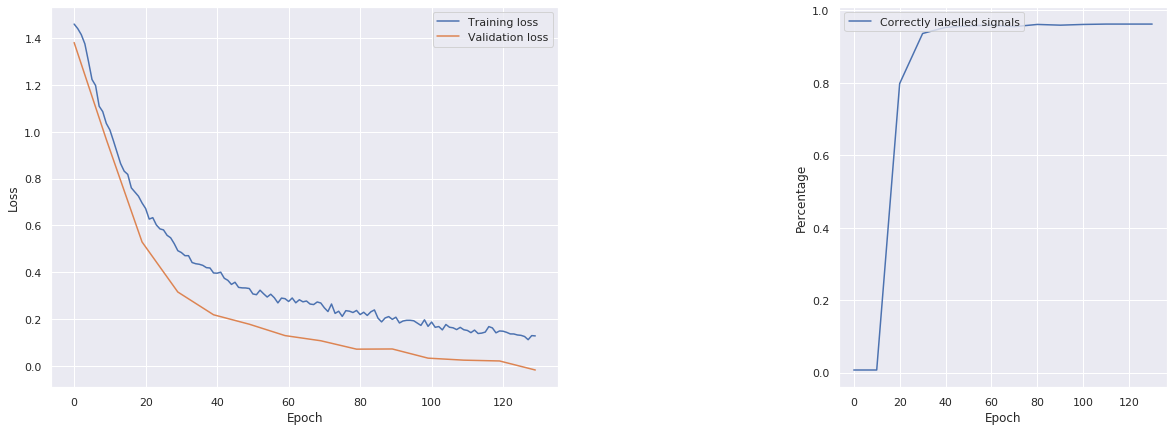

Epoch: 139


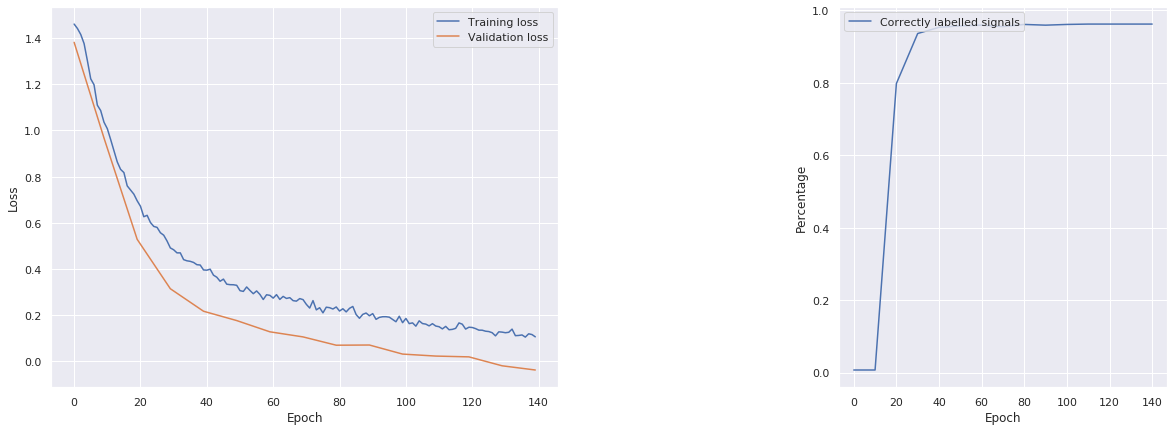

Epoch: 149


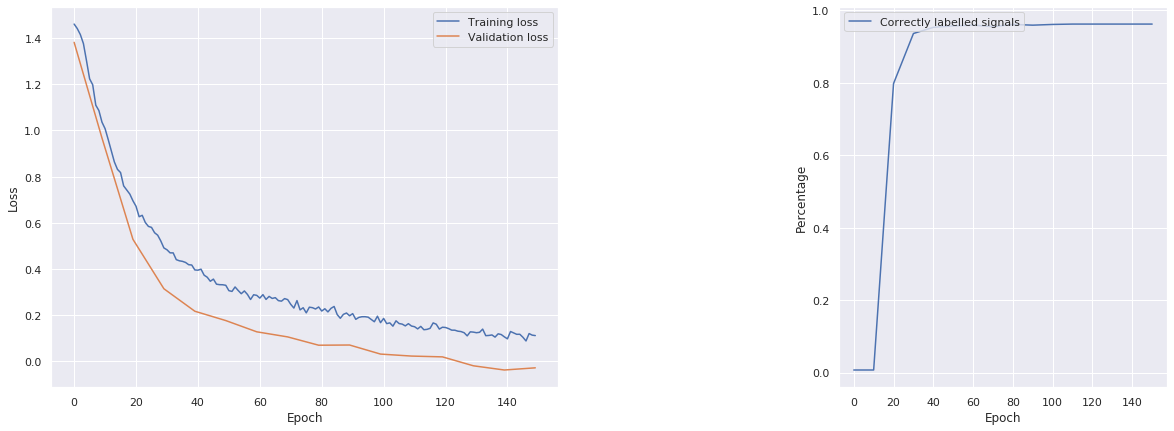

Epoch: 159


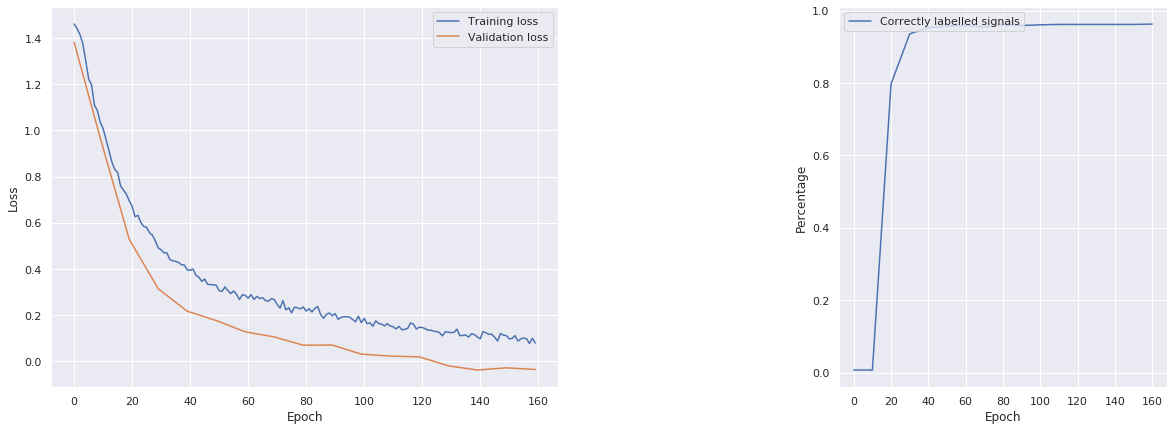

Epoch: 169


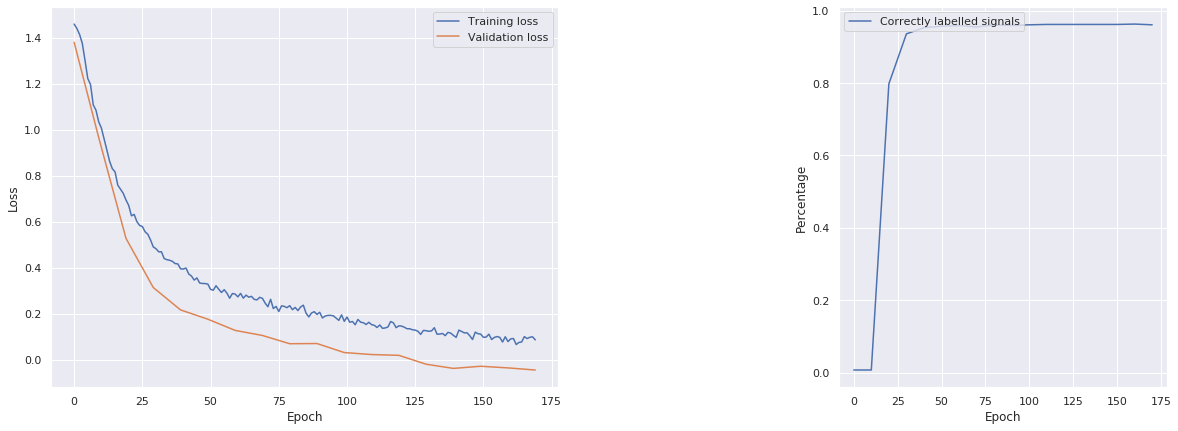

Epoch: 179


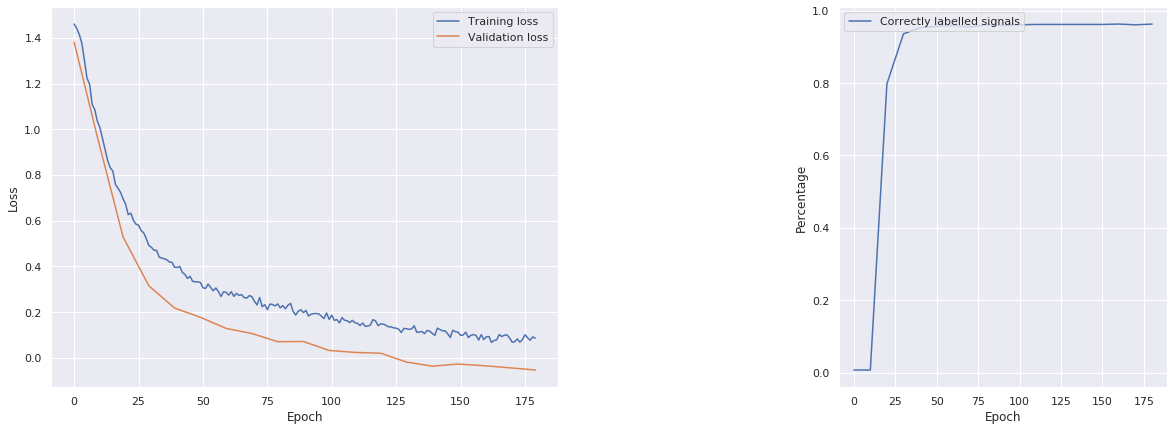

Epoch: 189


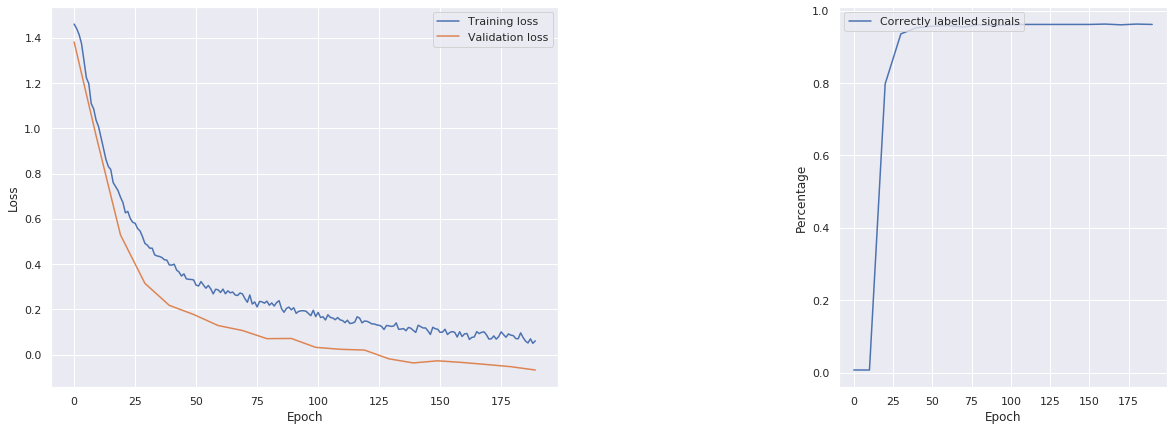

Epoch: 199


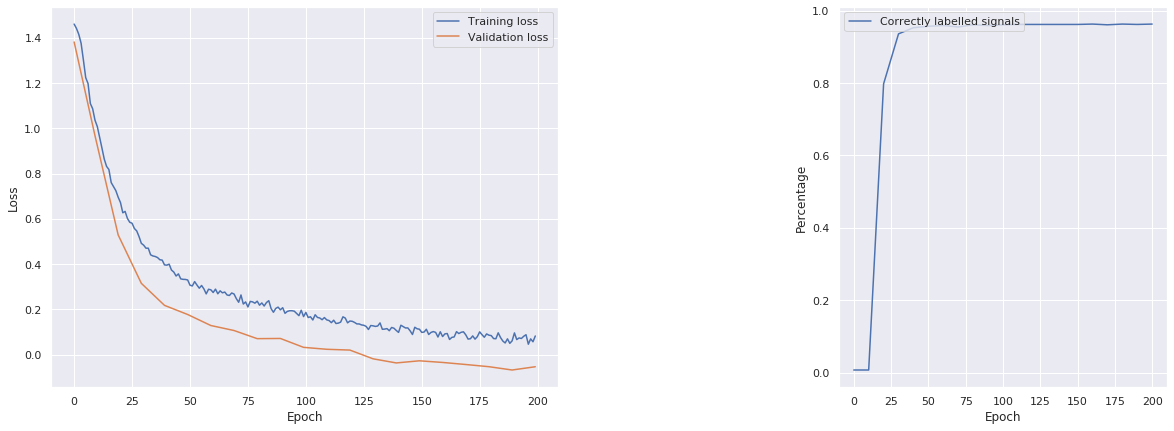

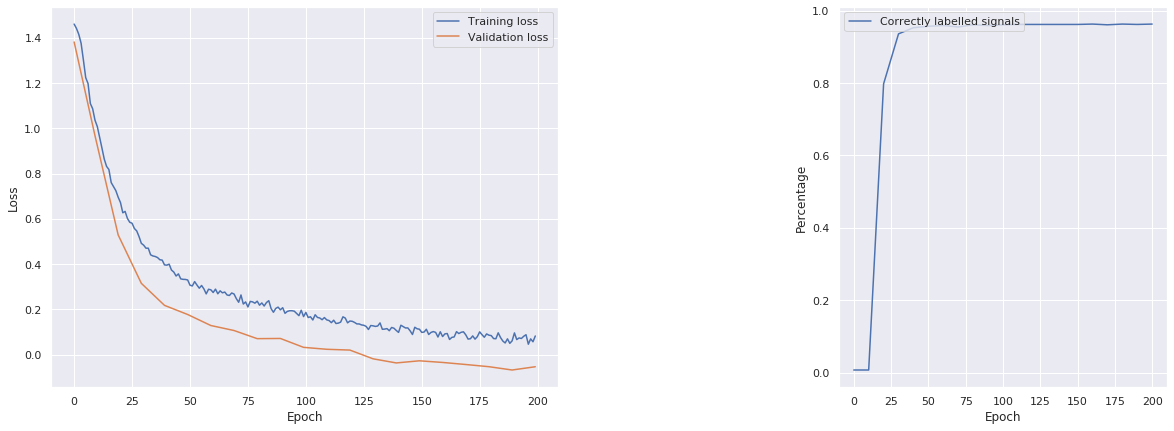

In [40]:
epochs_LSTM = 200
params_distribution = 2
hidden_layer_size = 512

#define the network
net = Standard_LSTM(features, params_distribution, hidden_layer_size)
#push it to the correct device
net.to(device)
#define the loss function
loss_function = loss_function_normal
#define the optimizer with the learning rate
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = 0.00000001)
#here we define the scheduler
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

#run the training
net_state_dict, train_fig = train_network(device, train_loader, valid_dataset , epochs_LSTM, net, loss_function,\
                                          optimizer, scheduler= scheduler)
net_state_dict_LSTM = net_state_dict
train_fig_LSTM = train_fig
plt.show()

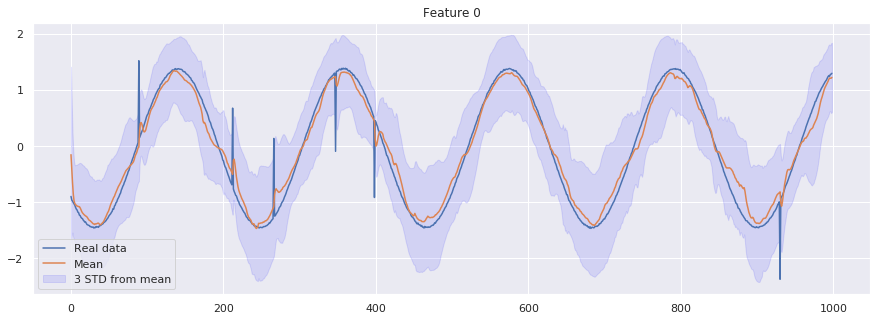

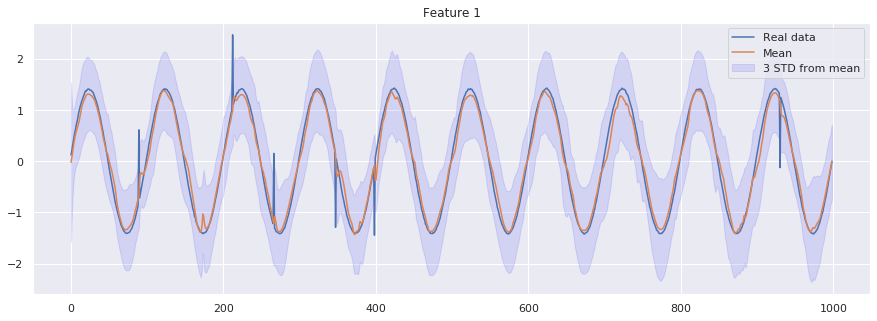

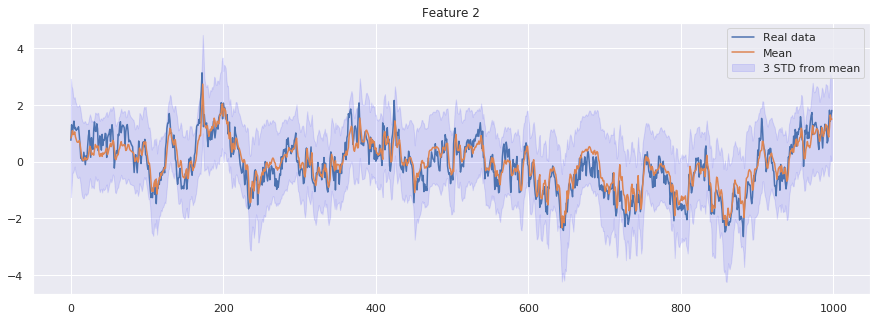

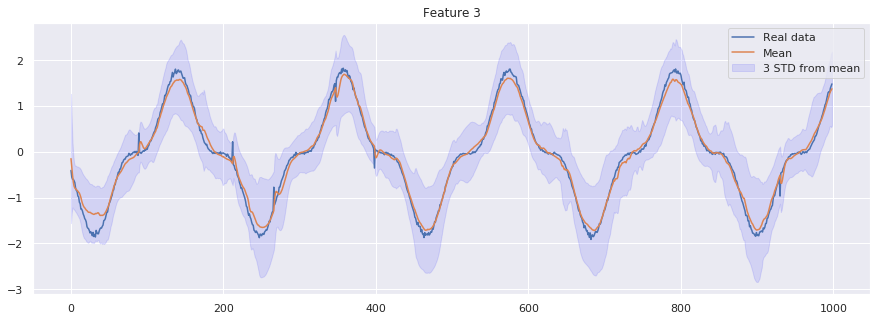

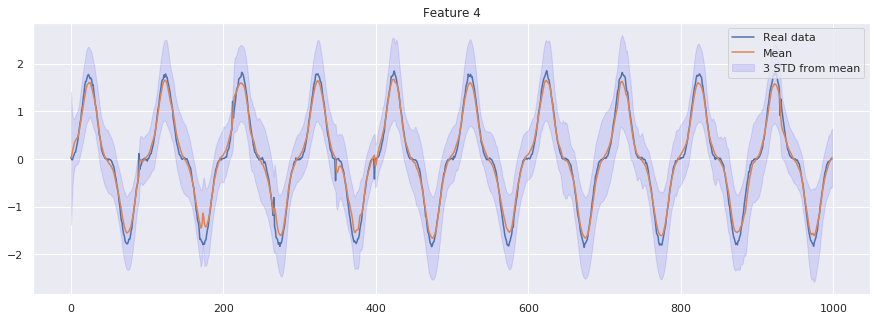

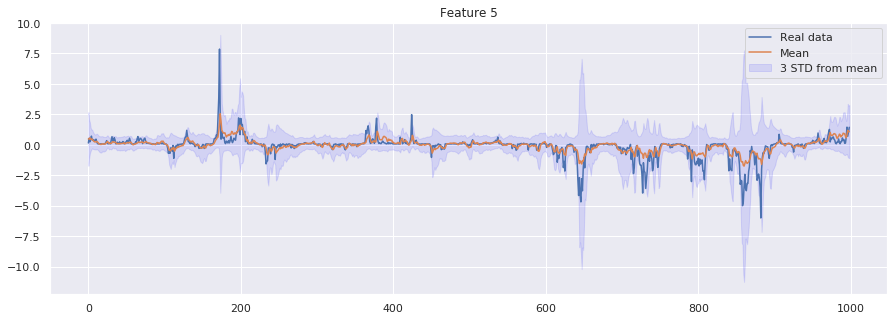

In [41]:
# start time of plotting
A = 0
# end time of plotting
B = 1000
# select the sequence to test the network on
sequence = train_dataset.get_data()[0]
sequence = valid_dataset.get_data()[0]

with torch.no_grad():
    # load the state of the trained network
    net.load_state_dict(net_state_dict)    
    
    # get it to the device and  put the batch dimension
    prepared_sequence = (sequence).to(device).unsqueeze(0)
    
    # run the model
    output_model = net(prepared_sequence, device)

    # extract the parameters at each time step
    mu, logvar = torch.chunk(output_model["params"], 2, dim=-1)
    std_dev = torch.exp(logvar/2)

    # PLOTTING
    # extract start and end points
    Ti = max(0, A)
    Tf = min(B, sequence.shape[0])
    time_axis = list(range(Ti,Tf-1))
    
    output_model_figs_LSTM = []
    
    for dimension in range(sequence.shape[1]):
        mean = torch.mean(mu, dim = 1)[Ti:Tf-1,dimension].cpu()
        std = 3*torch.mean(std_dev, dim = 1)[Ti:Tf-1,dimension].cpu()

        fig = plt.figure(figsize = (15,5))
        plt.title("Feature {}".format(dimension))
        plt.plot(time_axis, sequence[Ti+1:Tf,dimension], label = "Real data")
        plt.plot(time_axis, mean, label="Mean")
        plt.fill_between(time_axis, mean - std, mean + std,
                 color='blue', alpha=0.1, label="3 STD from mean")
        plt.legend()
        output_model_figs_LSTM.append(fig)
        plt.show()


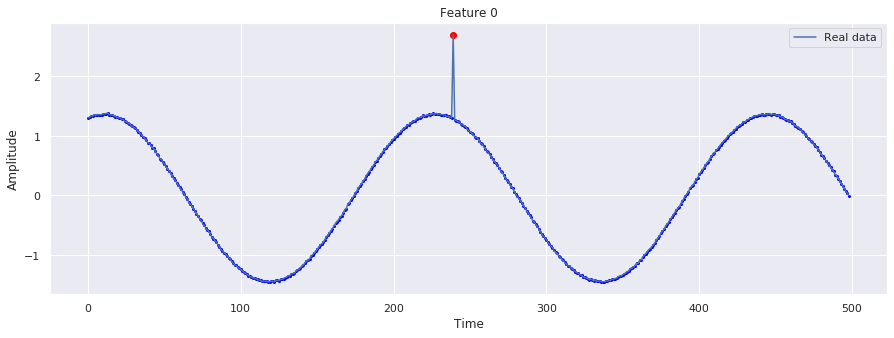

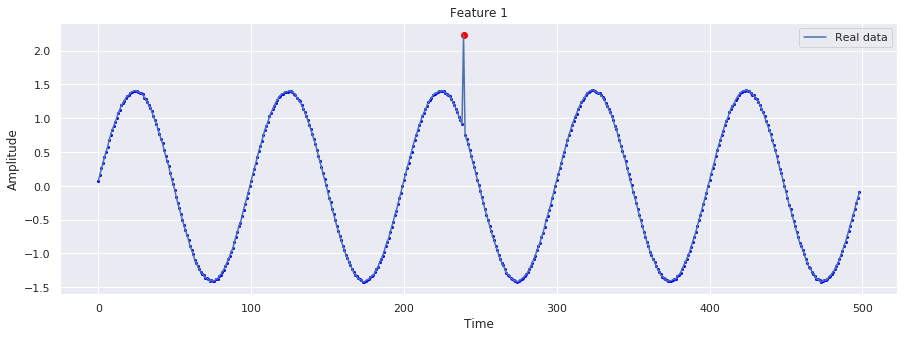

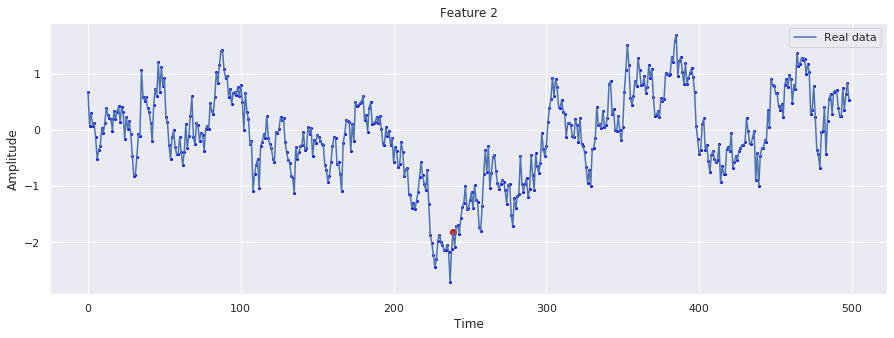

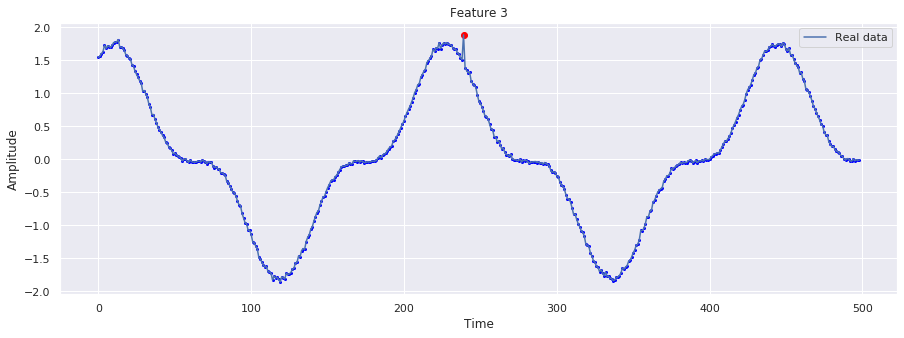

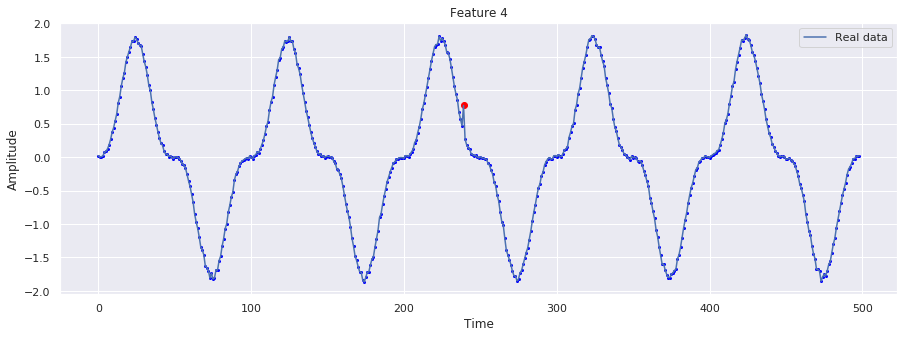

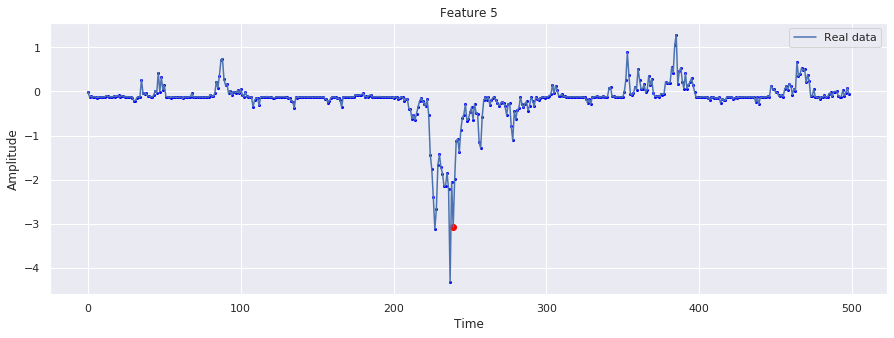

In [54]:
sequence = valid_dataset.get_data()[0]
sequence = test_dataset.get_data()[0]

percentage = 0.005
anomaly_data = detect_anomalies(sequence, net, device, percentage/100, False)
anomalies_figs_LSTM = plot_anomalies(anomaly_data, sequence, 0, 1000)

In [57]:
predictions = anomaly_data["outlier_label"]
ground_truth = valid_dataset.get_data()[1]
ground_truth = test_dataset.get_data()[1]

correct = 0
total = len(predictions) - 1
false_positives = 0
false_negatives = 0
anomaly_count = 0
for i in range(total):
    if ground_truth[i] == True:
        anomaly_count += 1
    if predictions[i] == ground_truth[i]:
        correct += 1
    elif predictions[i] == False:
        false_negatives += 1
    elif predictions[i] == True:
        false_positives += 1
accuracy_LSTM = {
    # number of labels correctly predicted
    "correct": correct,  
    # false positives (the datapoint was not an anomaly but it was predicted as one)
    "false_positives": false_positives,
    # false negatives (the datapoint was an anomaly abut it was not predicted as one)
    "false_negatives": false_negatives,
    # total number of datapoints in the sequence
    "total": total,
    # total number of anomalies
    "anomaly_count": anomaly_count
}
print(accuracy_LSTM)

{'correct': 499, 'false_positives': 0, 'false_negatives': 0, 'total': 499, 'anomaly_count': 1}


# VI approach

The most challenging part of training the VI apporach model was making sure that the KL divergence was greater than 0. 

We applied an annealing of the KL term during training to achieve this, however, it was not as straightforward as it sounds.

We noticed that, when increasing the complexity of the model, the KL divergence was more likely to be greater than 0, however, this lead to overfitting. This held true even for regularization, the more was applied, the smaller the KL divergence was. Another important thing to note is that the annealing was dependent on the number of epochs, meaning that a slower of faster training would affect it.

A number of factors go into managing the complexity of the model.

First, we can increase and decrease the complexity of the model directly by changing the number of units in each layer and the number of layers. This will lead to controlling the overfitting. Too small a model and the model is underfitting, uncapable of learning anything even of the training set. Too big a model and it overfits to the training set and achieves a poor result in the validation set.

Second, after we manage to overfit the model we can regularize it by applying weight decay or other regularization methods (dropout, batching). This will affect the KL divergence. Bigger regularization means that now the KL divergence will be more likely small, as regularization can be interpreted as a way to keep the model simpler.

Third, using the coefficient of the KL term of the loss we can increase regularization.

Forth, stopping the training early would help with overfitting. In our task in particular, stopping early means that the model learns a representation of the signal with a bigger variance, leading to similar results to those achieved with a model which tightly follows the time series. This means that choosing the right learning rate is also important.

In [ ]:
class Variational_LSTM(nn.Module):
    def __init__(self, input_dim, param_dist, hidden_dim_rec, hidden_dim_gen, latent_dim):
        super(Variational_LSTground_truth = valid_dataset.get_data()[1]
M, self).__init__()

        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.hidden_dim_rec = hidden_dim_rec
        self.hidden_dim_gen = hidden_dim_gen

        self.relu = nn.ReLU()

        # encoder net, recognition model q(z_t+1|x_1:t)
        self.encoder_LSTM = nn.LSTM(input_size=input_dim,
                                    hidden_size=hidden_dim_rec,  # 2 because we want mu and sigma
                                    num_layers=1
                                    )
        self.encoder_hidden2hidden = nn.Linear(hidden_dim_rec, hidden_dim_rec)

        self.enc2latent = nn.Linear(hidden_dim_rec, 2 * latent_dim)

        # decoder net p(x_t+1|x_1:t,z_1:t)

        self.decoder_LSTM = nn.LSTM(input_size=input_dim + latent_dim,
                                    hidden_size=hidden_dim_gen,
                                    num_layers=1
                                    )

        self.decoder_hidden2hidden = nn.Linear(hidden_dim_gen, hidden_dim_gen)

        self.dec2features = nn.Linear(hidden_dim_gen, param_dist * input_dim)

        self.decoder = nn.Sequential(
            self.decoder_LSTM,
            self.decoder_hidden2hidden,
            nn.ReLU(),
            self.dec2features
        )

    def forward(self, x, device):
        outputs = {}
        outputs["x_input"] = x
        batch_size = x.shape[0]
        seq_length = x.shape[1]
        # --- recognition LSTM to generate latent variable(s) for each time step --- #

        # get x in the right format: [seq_length, batch_size, input_dimension]
        x_encoder = x.permute(1, 0, 2)
        encoder_out, (h, c) = self.encoder_LSTM(x_encoder)
        # add non-linearities and a level of abstraction
        #encoder_out = self.relu(self.encoder_hidden2hidden(encoder_out))
        encoder_out = self.relu(encoder_out)
        # [seq_len, batch_dim, features]
        x_latent = self.enc2latent(encoder_out)  # outputs the latent variable parameters mu and sigma

        # make the network learn the log of the variance it is non-negative (log only takes pos x)
        mu, log_var = torch.chunk(x_latent, 2, dim=-1)
        sigma = torch.exp(log_var / 2)  # std of the latent variable distribution
        # reparameterization trick happens here:
        epsilon = 0
        with torch.no_grad():
            epsilon = torch.randn(seq_length,
                                  batch_size,
                                  self.latent_dim,
                                  # latent_samples here, but should only be one as we concatenate it to the oringinal x
                                  ).to(device)  # 10 is the num of latent samples
        # create the random latent variable, reparametrization trick
        z = mu + sigma * epsilon

        # store intermediate results and latent variables
        outputs["z"] = z
        outputs["z_mu"] = mu
        outputs["z_sigma"] = sigma
        outputs["z_log_var"] = log_var

        # --- ordinary LSTM to predict the next x in the time sequence --- #
        # concatenate the latent variables with the original input x
        # [sequence_len, batch_size, dimensions]
        x_aug = torch.cat((x_encoder, z), dim=-1)  # aug = augmented x, because we augment x with z
        # x_aug = x_aug.view(seq_len, self.batch_size, self.input_dim + self.latent_dim)

        # run it through the ordinary LSTM
        decoder_out, (h, c) = self.decoder_LSTM(x_aug)
        # symmetry with encoder
        #decoder_out = self.relu(self.decoder_hidden2hidden(decoder_out))
        decoder_out = self.relu(decoder_out)

        # [sequence_len, batch_size, dimensions]
        params = self.dec2features(decoder_out)

        # store the outputs in the form (batch_size, seq_length, input_dim)
        outputs["params"] = params

        return outputs


def loss_normal2d(model_output, device, beta):
    # unpack the required quantities
    x_true = model_output["x_input"].permute(1, 0, 2)
    params = model_output["params"]
    mu, logvar = torch.chunk(params, 2, dim=-1)
    sigma = torch.exp(logvar / 2)

    z_mu = model_output["z_mu"]
    z_log_var = model_output["z_log_var"]

    seq_length = mu.shape[0]
    # iterate over each time step in the sequence to compute NLL and KL terms

    t = 0
    cov_matrix = torch.diag_embed(sigma[t, :, :])
    # define the distribution
    p = distributions.MultivariateNormal(mu[t, :, :], cov_matrix)
    log_prob = torch.mean(p.log_prob(x_true[t + 1, :, :]), dim=-1)
    # dimensions [batch_size, dimension]
    ones_vector = torch.ones((z_mu.shape[1], z_mu.shape[2])).to(device)
    # KL-divergence
    kl = 0.5 * torch.sum(ones_vector + z_log_var[t, :, :] - z_mu[t, :, :] ** 2 - torch.exp(z_log_var[t, :, :]), dim=-1)

    for t in range(1, seq_length - 1):
        # print(t)
        # construct (diagonal) covariance matrix for each time step based on
        # the estimated var from the model
        cov_matrix = torch.diag_embed(sigma[t, :, :])

        # define the distribution
        #        p = distributions.Normal(mu[:, t, :], sigma[:, t, :])
        p = distributions.MultivariateNormal(mu[t, :, :], cov_matrix)

        log_prob += torch.mean(p.log_prob(x_true[t + 1, :, :]), dim=-1)
        # KL-divergence
        kl += 0.5 * torch.sum(ones_vector + z_log_var[t, :, :] - z_mu[t, :, :] ** 2 -
                              torch.exp(z_log_var[t, :, :]))

    NLL, KL = -torch.mean(log_prob, dim=0) / (seq_length - 1), -torch.mean(kl, dim=0) / (seq_length - 1)

    ELBO = NLL + beta * KL

    return {
        "loss": ELBO,
        "ELBO": ELBO,
        "NLL": NLL,
        "KL": KL
    }


def loss_normal2d_lognormal(model_output, device, beta):
    # unpack the required quantities
    x_true = model_output["x_input"].permute(1, 0, 2)
    params = model_output["params"]
    mu, logvar = torch.chunk(params, 2, dim=-1)
    sigma = torch.exp(logvar / 2)

    z_mu = model_output["z_mu"]
    z_log_var = model_output["z_log_var"]

    seq_length = mu.shape[0]
    # iterate over each time step in the sequence to compute NLL and KL terms

    t = 0
    # define the distribution
    p = distributions.LogNormal(mu[t, :, :], sigma[t, :, :])
    log_prob = torch.mean(p.log_prob(x_true[t + 1, :, :]), dim=-1)
    # dimensions [batch_size, dimension]
    ones_vector = torch.ones((z_mu.shape[0], z_mu.shape[2])).to(device)
    # KL-divergence
    kl = 0.5 * torch.sum(ones_vector + z_log_var[t, :, :] - z_mu[t, :, :] ** 2 - torch.exp(z_log_var[t, :, :]), dim=-1)

    for t in range(1, seq_length - 1):
        # define the distribution
        #        p = distributions.Normal(mu[:, t, :], sigma[:, t, :])
        p = distributions.LogNormal(mu[t, :, :], sigma[t, :, :])

        log_prob += torch.mean(p.log_prob(x_true[t + 1, :, :]), dim=-1)
        # KL-divergence
        kl += 0.5 * torch.sum(ones_vector + z_log_var[t, :, :] - z_mu[t, :, :] ** 2 -
                              torch.exp(z_log_var[t, :, :]))

    NLL, KL = -torch.mean(torch.mean(log_prob, dim=-1), dim=0) / (seq_length - 1), -torch.mean(kl, dim=0) / (
                seq_length - 1)

    ELBO = NLL + beta * KL

    return {
        "loss": ELBO,
        "ELBO": ELBO,
        "NLL": NLL,
        "KL": KL
    }


Training has started.
Epoch: 0


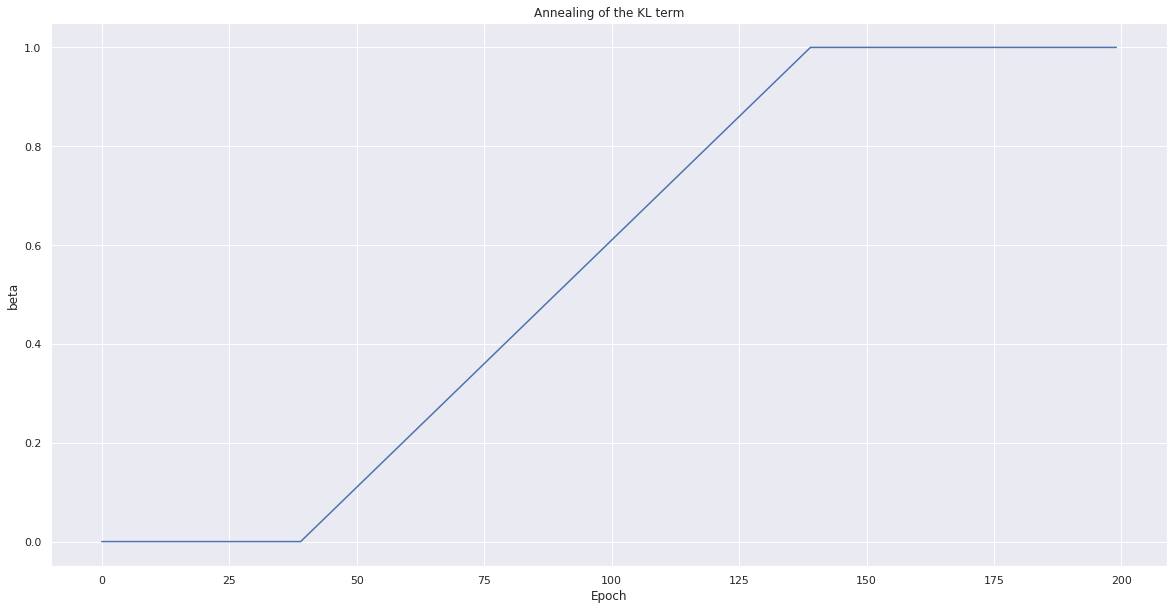

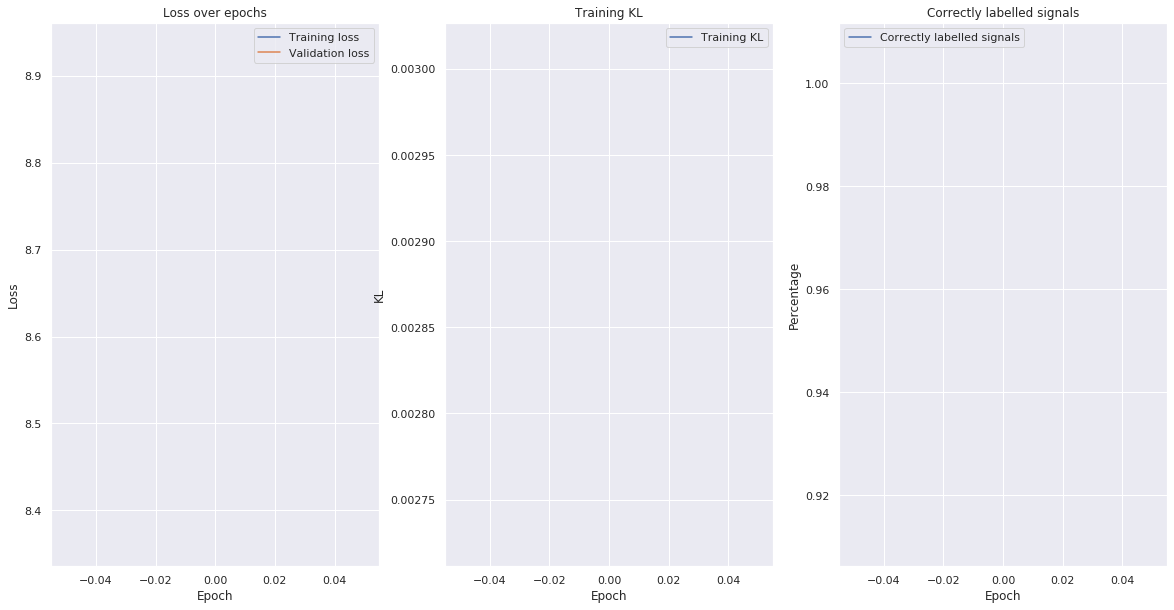

Epoch: 9


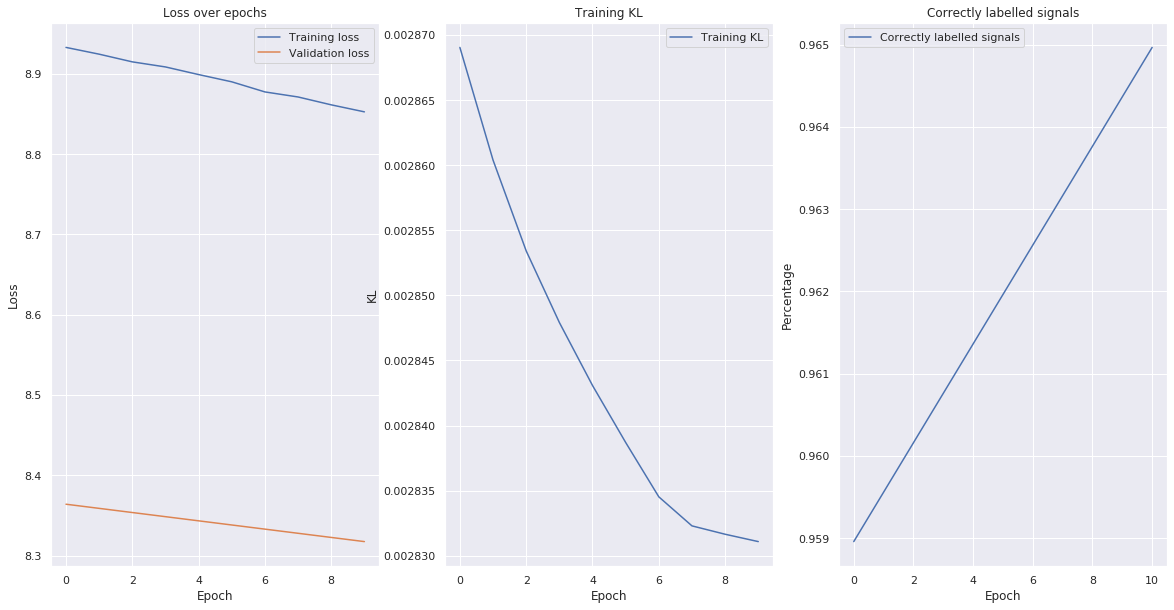

Epoch: 19


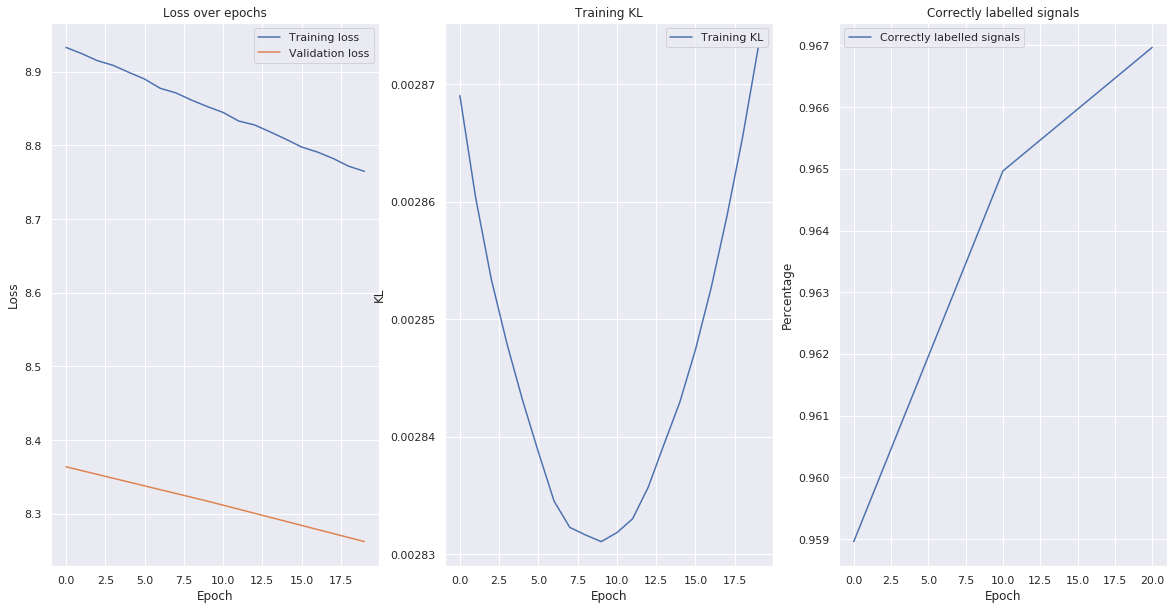

Epoch: 29


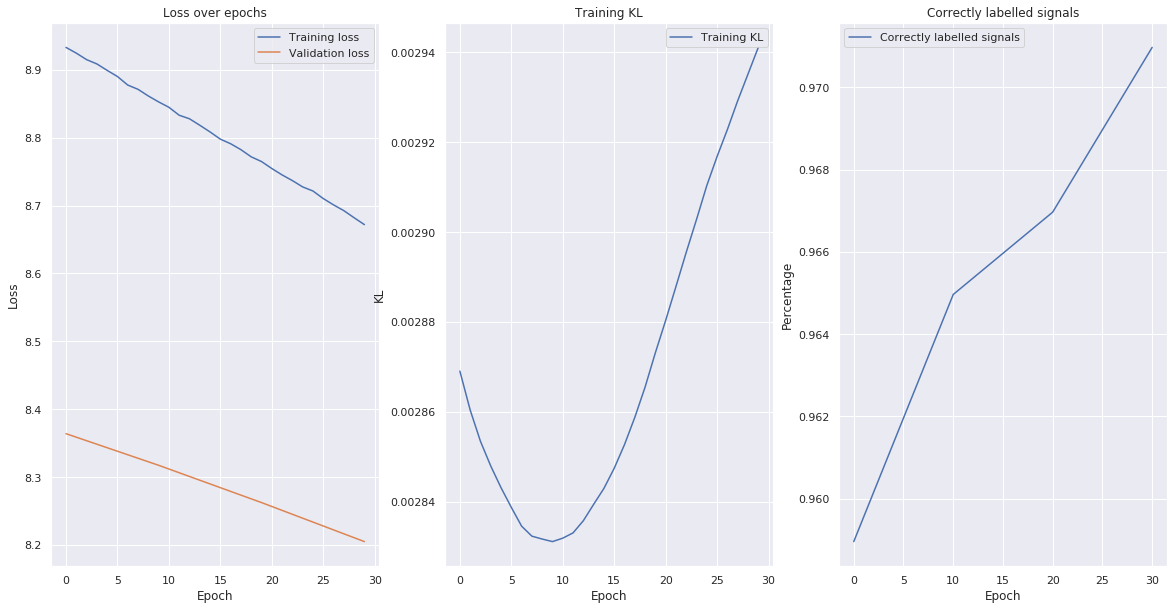

Epoch: 39


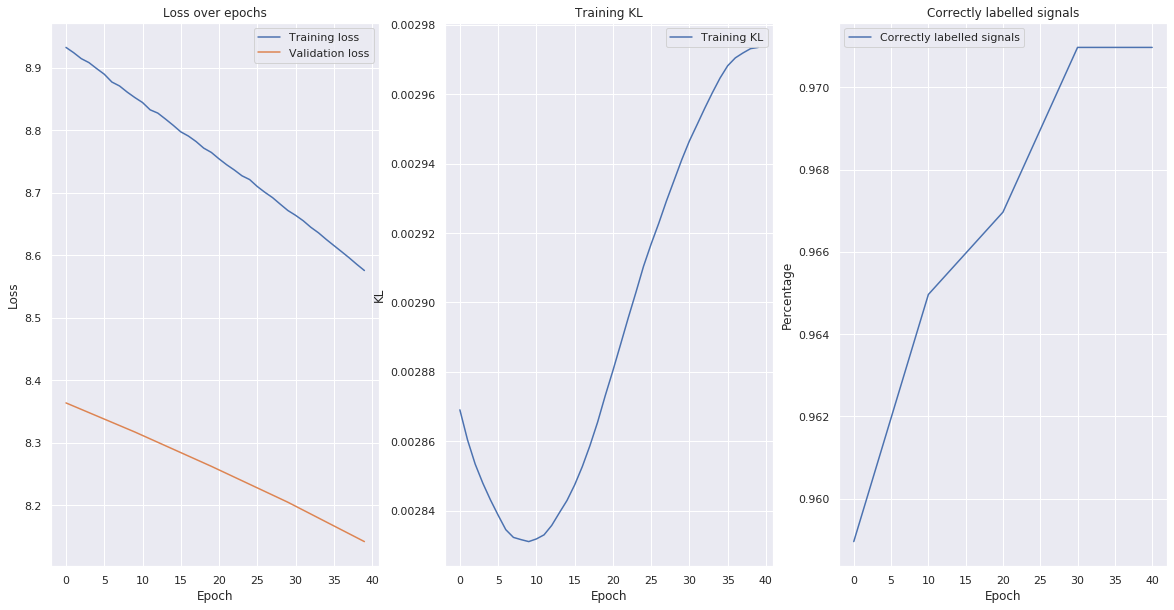

Epoch: 49


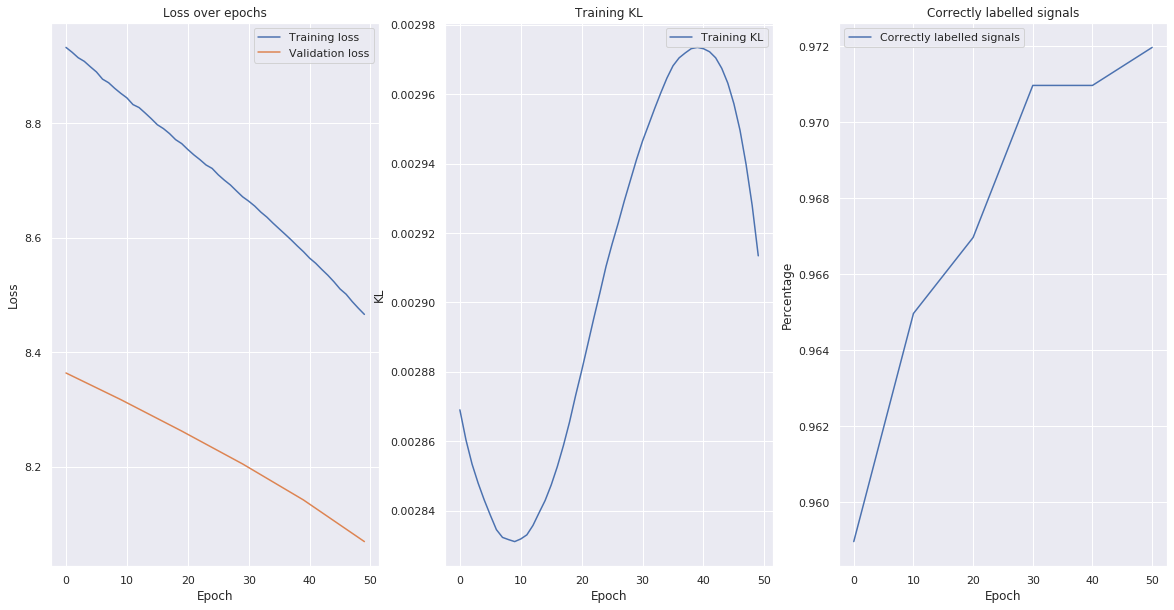

Epoch: 59


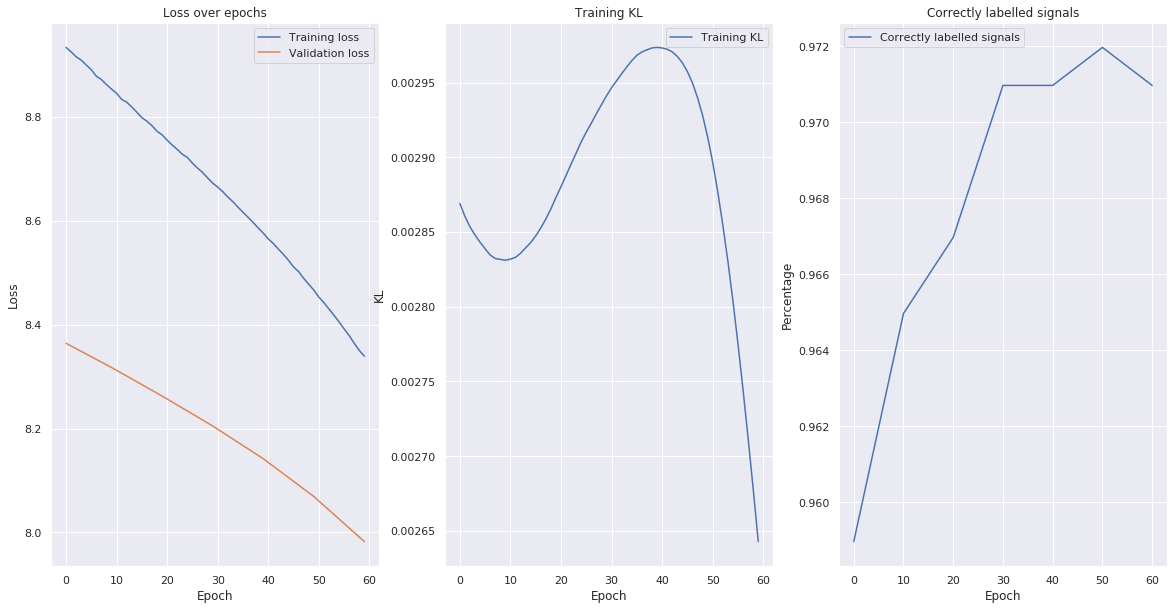

Epoch: 69


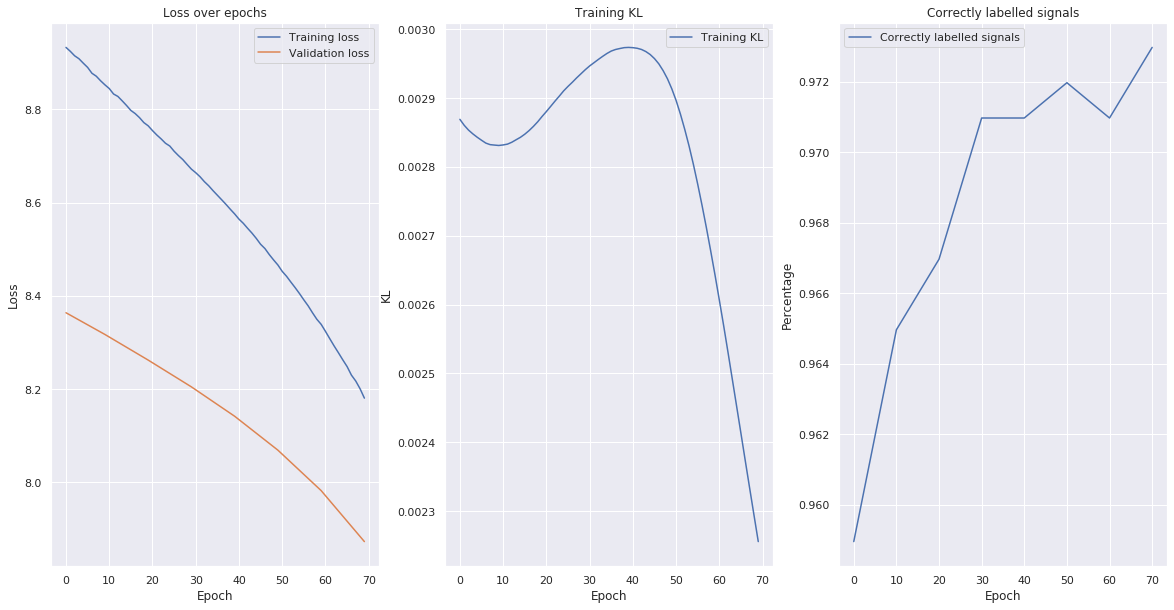

Epoch: 79


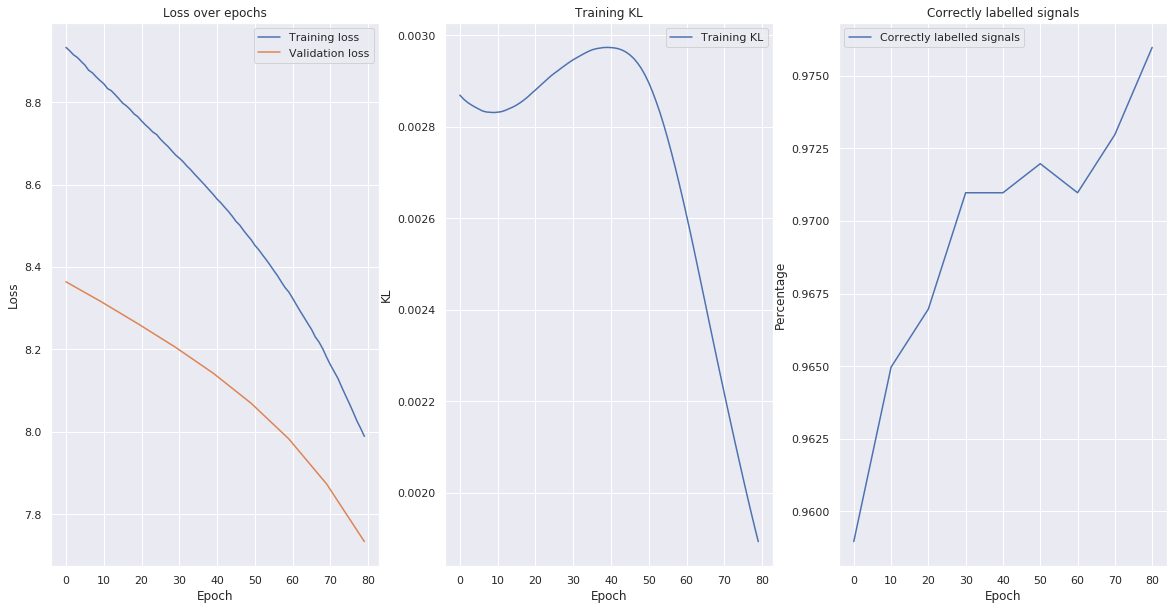

Epoch: 89


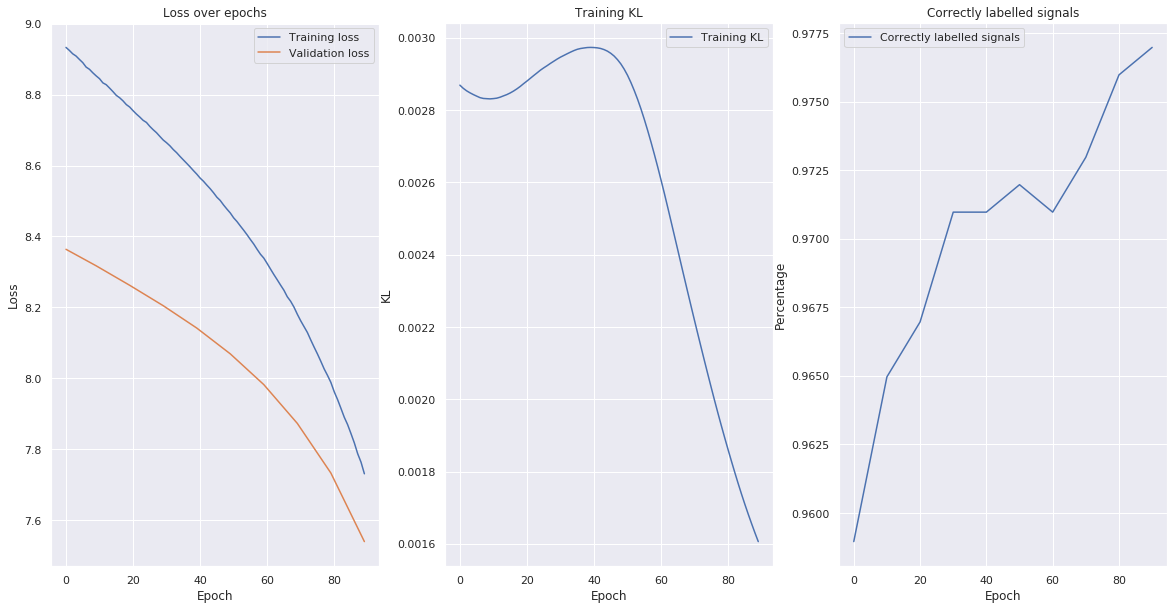

Epoch: 99


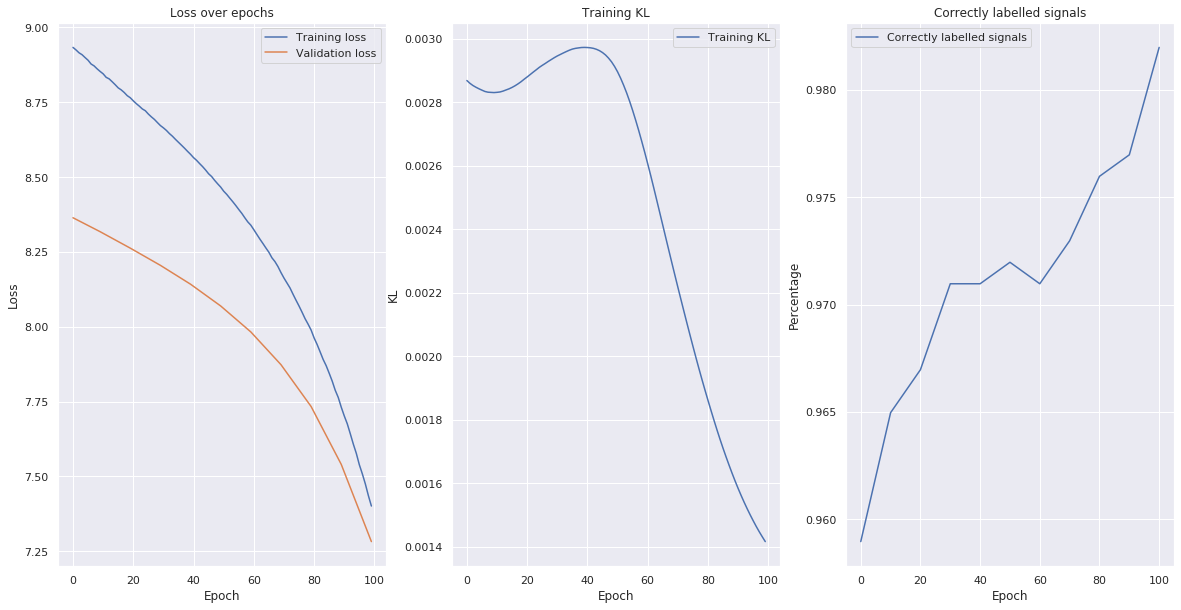

Epoch: 109


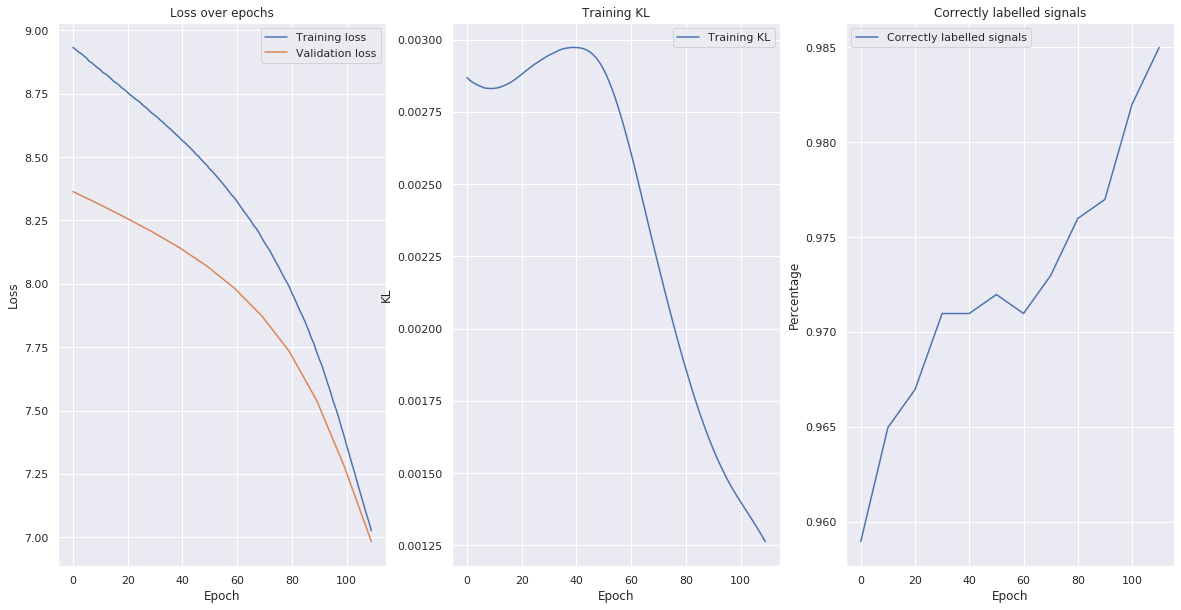

Epoch: 119


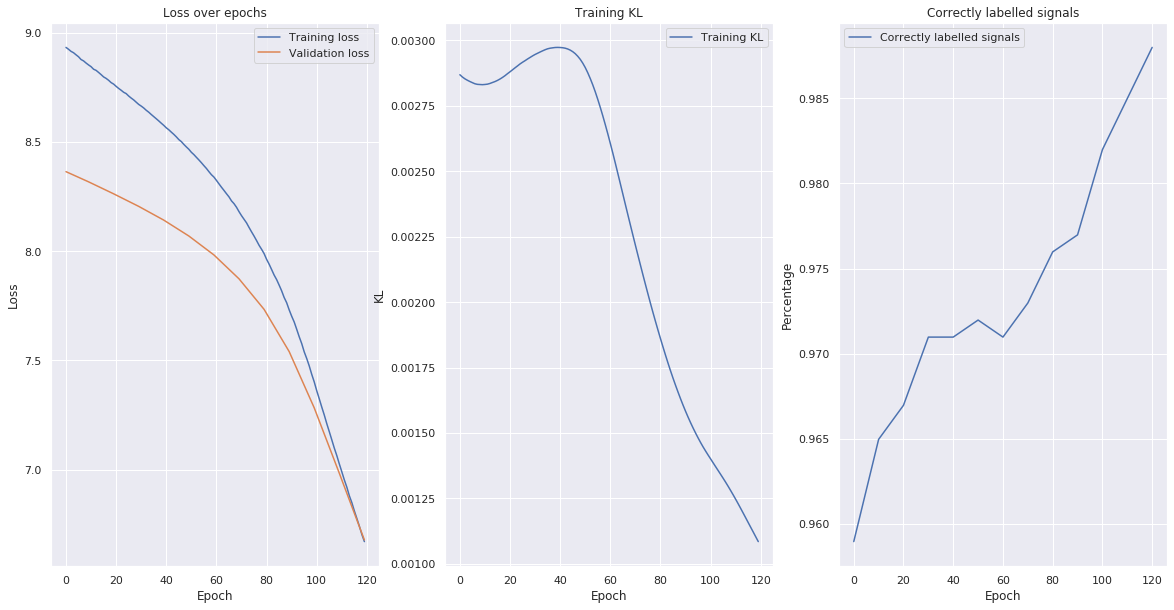

Epoch: 129


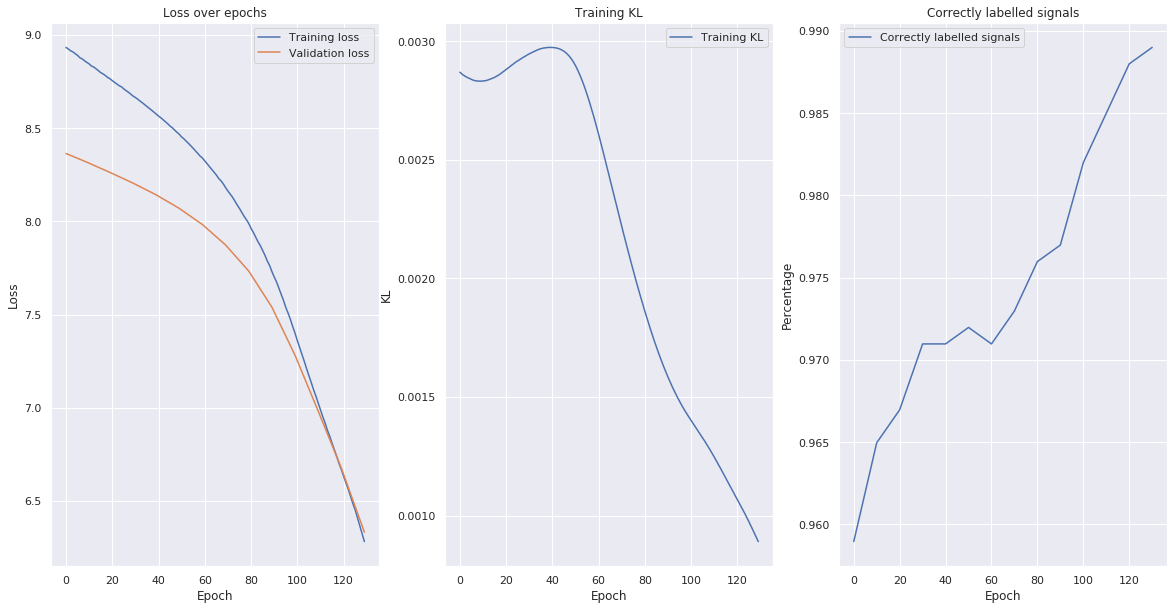

Epoch: 139


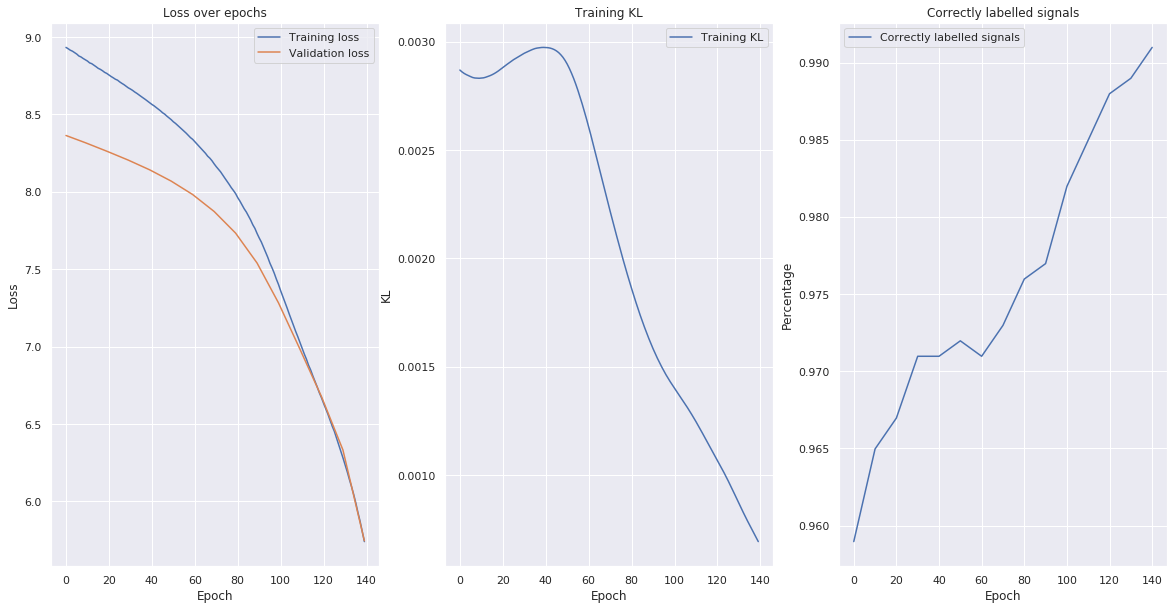

Epoch: 149


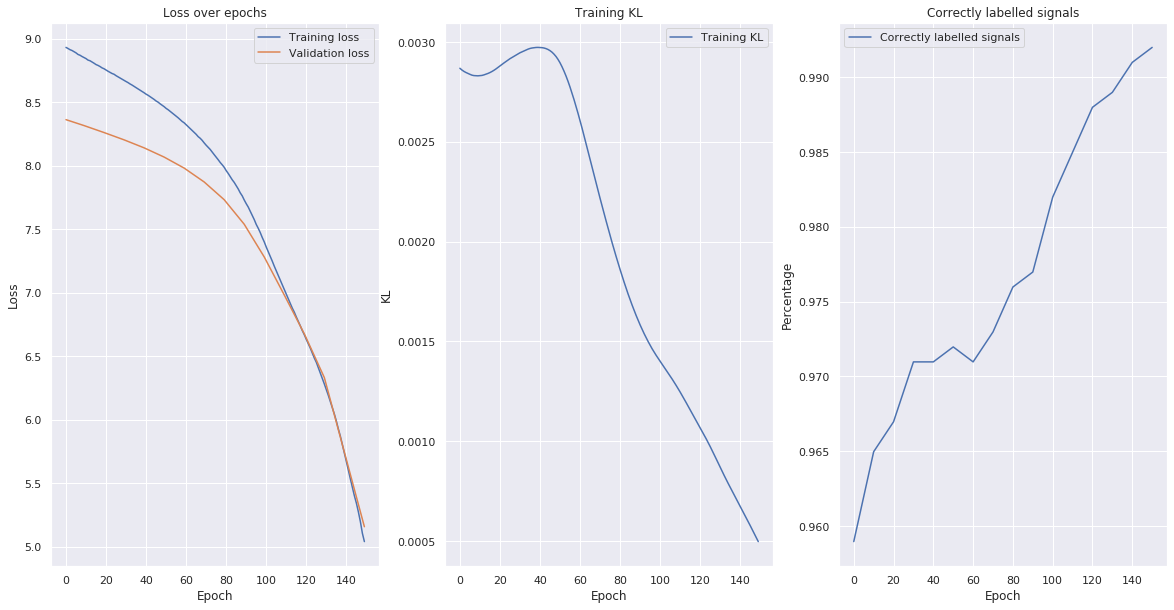

Epoch: 159


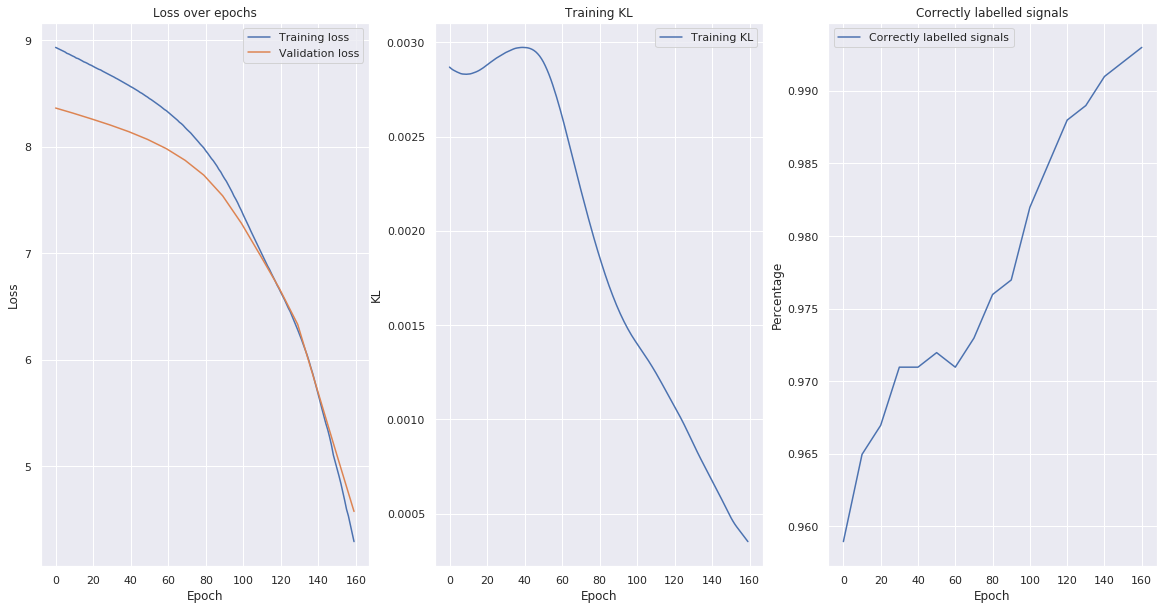

Epoch: 169


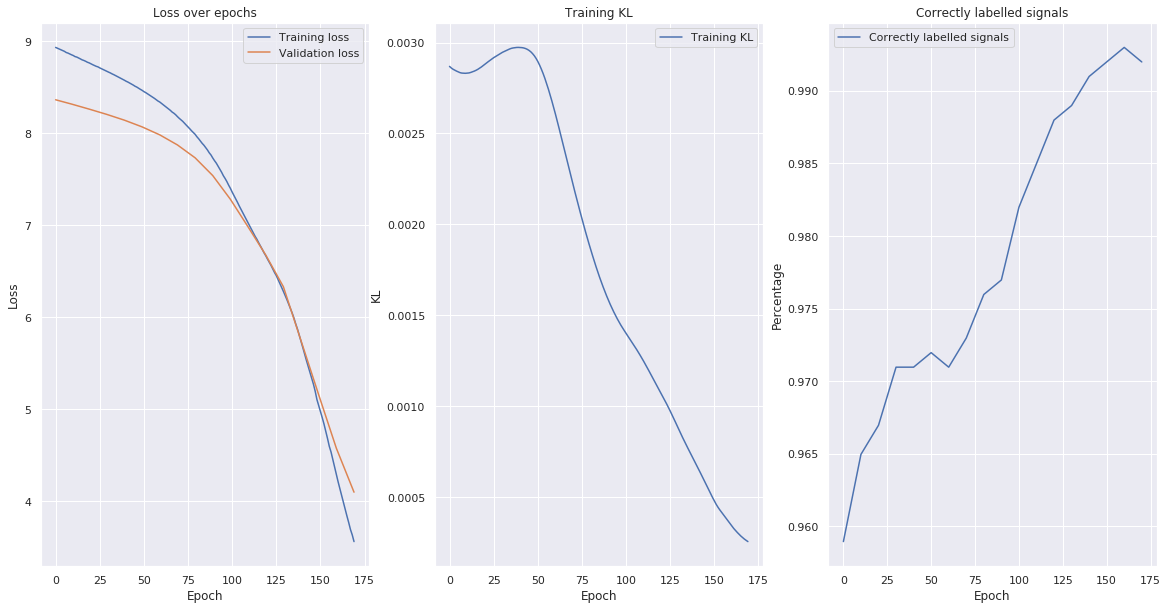

Epoch: 179


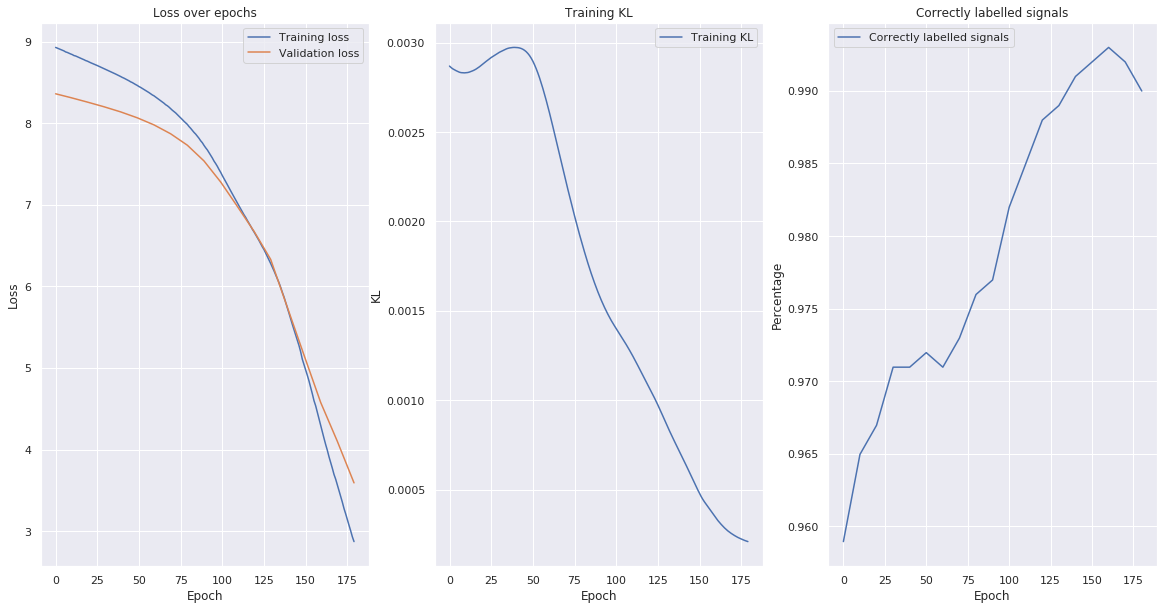

Epoch: 189


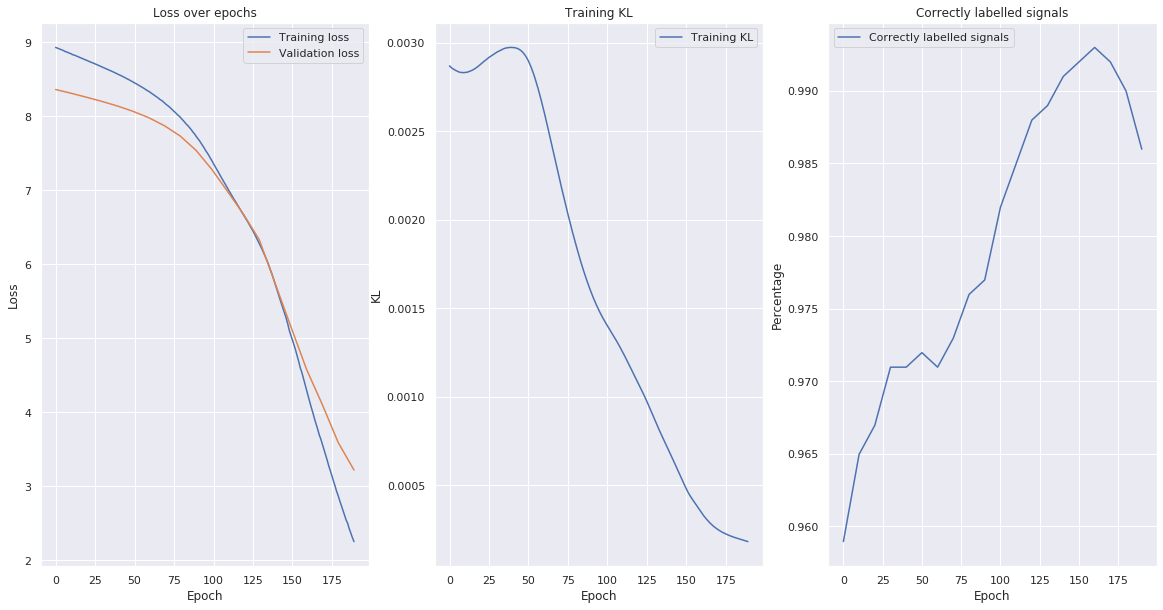

Epoch: 199


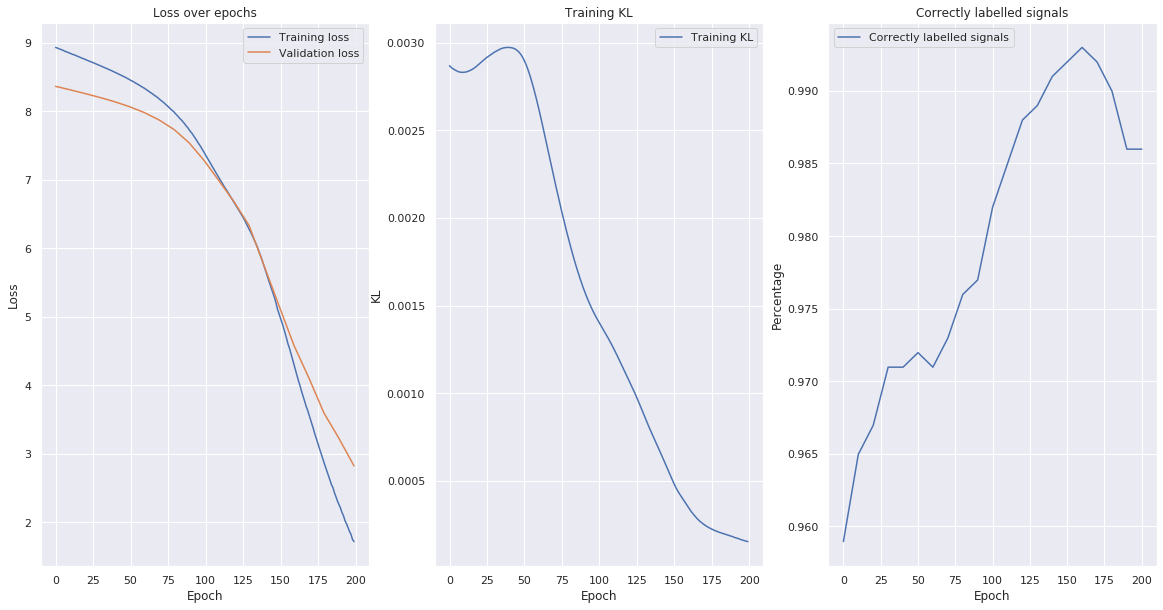

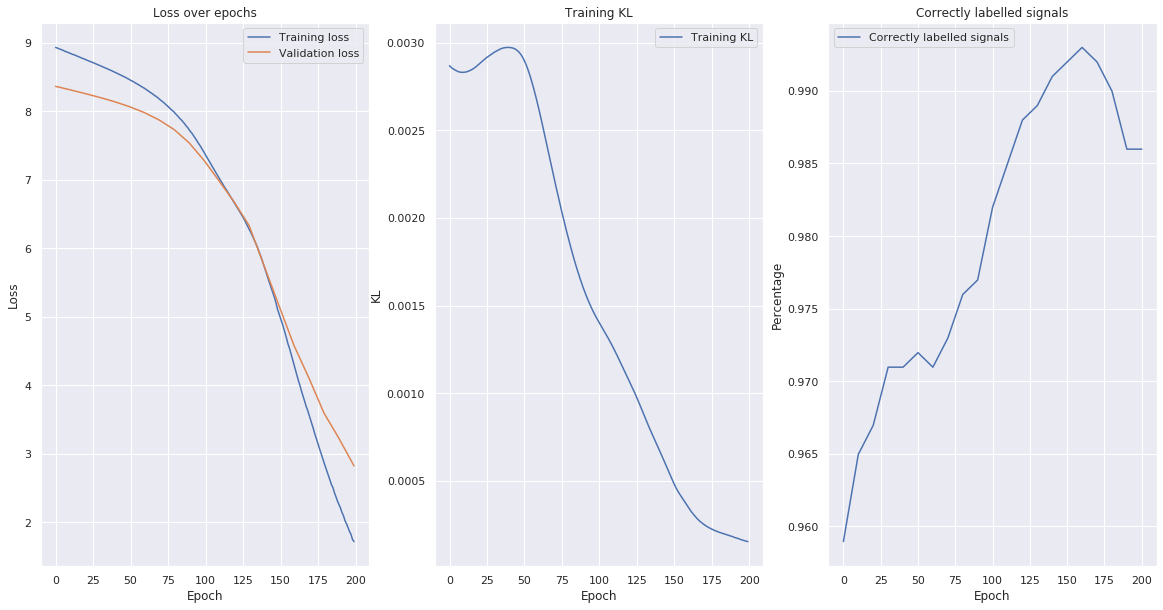

In [74]:
epochs_VAE = 200
params_distribution = 2
hidden_dim_gen = 256
hidden_dim_rec = 256                                                   
latent_dim = 3

#define the network
net = Variational_LSTM(features, params_distribution, hidden_dim_rec, hidden_dim_gen, latent_dim)
#push it to the correct device
net.to(device)
#define the loss function
loss_function = loss_normal2d
#define the optimizer with the learning rate
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay = 10*1e-3)
#here we define the scheduler
scheduler = StepLR(optimizer, step_size=100, gamma=0.001)
# beta annealing to reduce the effect of KL going to zero
def old_beta_annealing(beta, epoch):
    annealing_time = 1000
    k = 1/annealing_time
    initial_epoch = 40
    #initial_epoch = 20
    if epoch == 0:
        return 0
    if epoch < initial_epoch:
        return k
    #if epoch%10 == 0:
        #if epoch>150:
        #    return min(beta + 0.1*beta, 1)
        #if epoch>100:
        #    return min(beta + 0.1*beta, 1)
        #if epoch>50:
        #    return min(beta + 0.2*beta, 1)
    if beta < 0.5:
        return min(beta + 0.01*beta, 1)
    else:
        return min(beta + 0.01/beta, 1)
    #return beta
def sigmoid_beta_annealing(beta, epoch):
    k = 1.04 # steepness
    m = 250 # half time
    if beta<0.5:
        return (k**(epoch-m))/2
    else:
        return 1-(k**(m-epoch))/2
def heuristic_beta_annealing(beta, epoch):
    k1 = 1.05 # steepness
    k2 = 1.1
    m = 90 # half time
    if beta<0.75:
        return ((k1**(epoch-m))/4)*3
    else:
        return 1-((k2**(m-epoch))/4)
def linear_beta_annealing(beta, epoch):
    start_epoch = 40
    len_annealing = 100
    if epoch < start_epoch:
        return 0
    elif epoch < start_epoch + len_annealing:
        return min(beta + 1./len_annealing,1.)
    else:
        return 1
def no_beta_annealing(beta, epoch):
    return 0

betas = []
beta = 0
for epoch in range(epochs_VAE):
    betas.append(linear_beta_annealing(beta, epoch))
    beta = betas[-1]
plt.figure(figsize = (20,10))
plt.title("Annealing of the KL term")
plt.xlabel("Epoch")
plt.ylabel("beta")
plt.plot(list(range(len(betas))), betas)


#run the training
net_state_dict, train_fig = train_network(device, train_loader, valid_dataset, epochs_VAE, net, \
                                          loss_function, optimizer, linear_beta_annealing, scheduler = None, \
                                          p_anomaly = 1e-5)
net_state_dict_VAE = net_state_dict
train_fig_VAE = train_fig

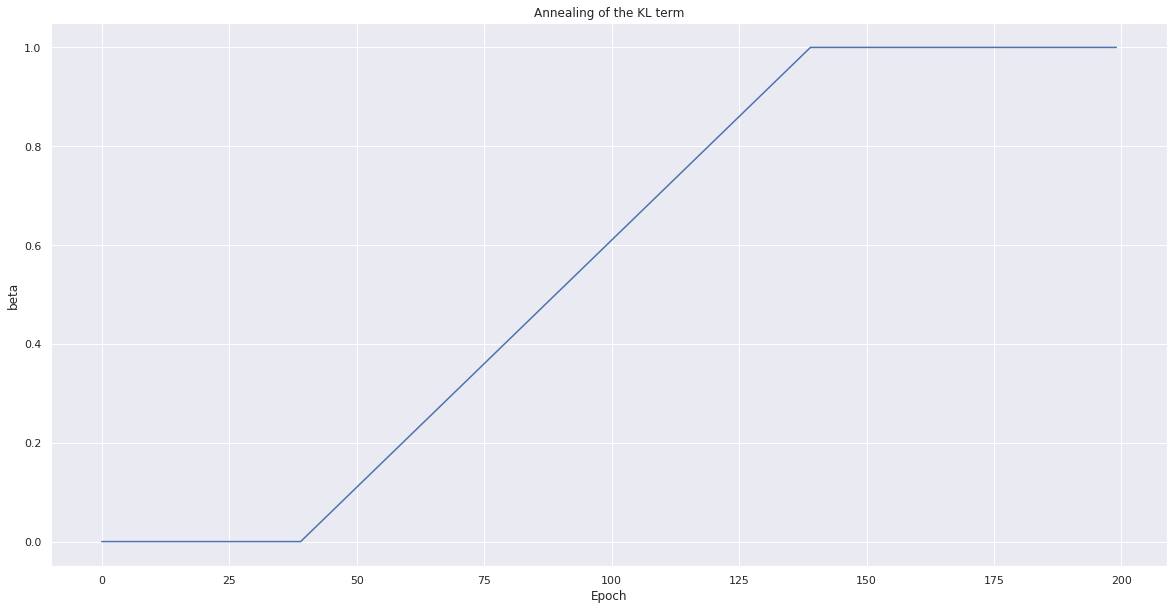

In [75]:
betas = []
beta = 0
for epoch in range(epochs_VAE):
    betas.append(linear_beta_annealing(beta, epoch))
    beta = betas[-1]
plt.figure(figsize = (20,10))
plt.title("Annealing of the KL term")
plt.xlabel("Epoch")
plt.ylabel("beta")
plt.plot(list(range(len(betas))), betas)

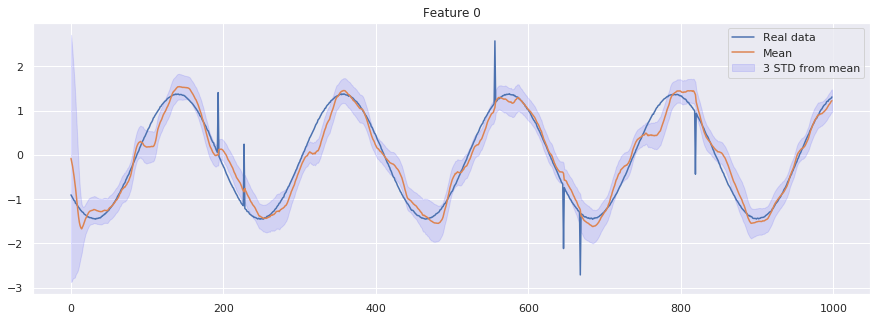

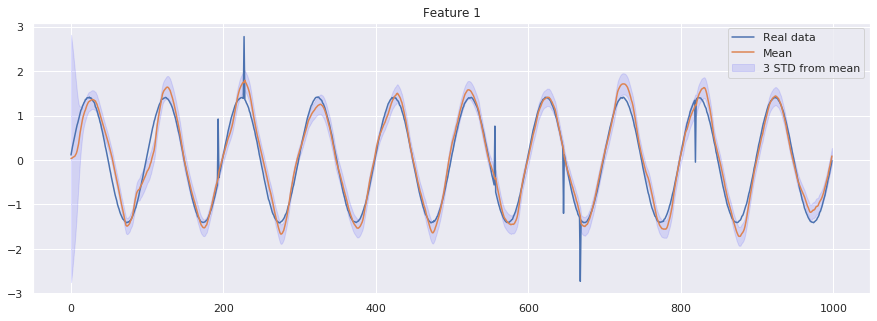

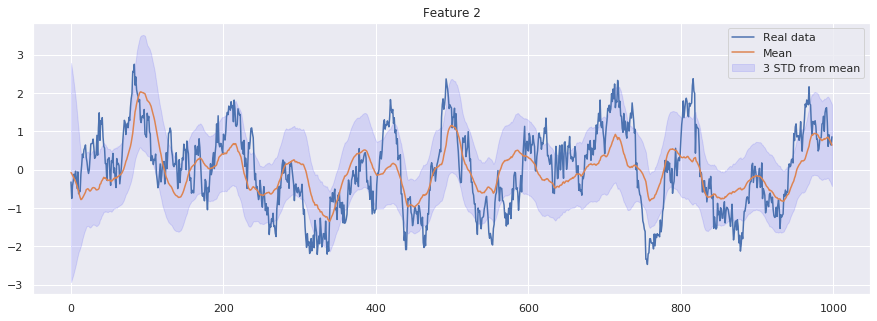

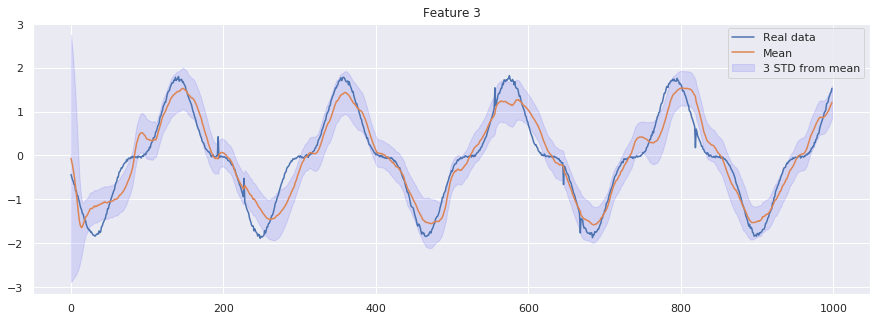

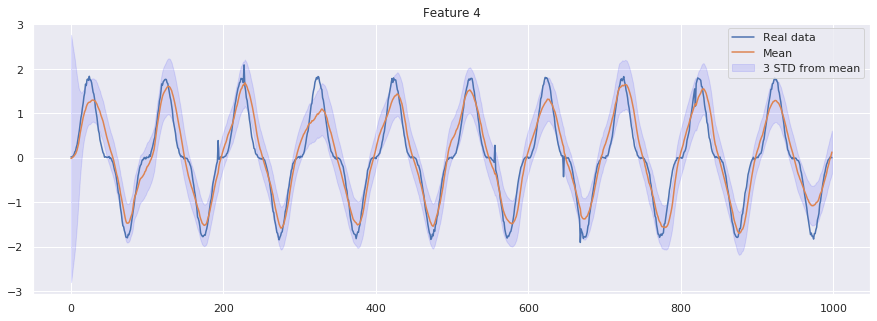

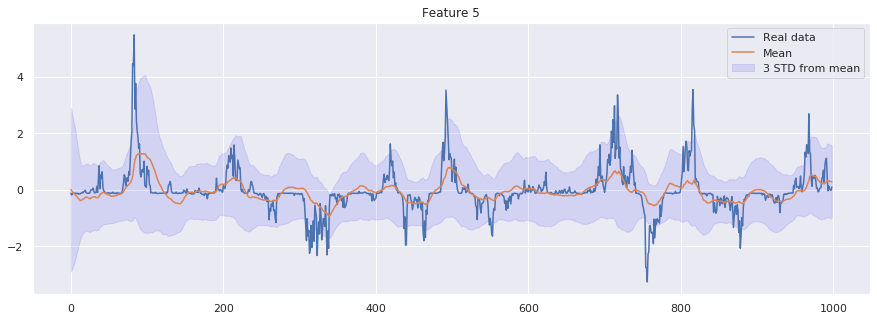

In [76]:
# start time of plotting
A = 0
# end time of plotting
B = 1000
# select the sequence to test the network on
sequence = test_dataset.get_data()[0]
sequence = train_dataset.get_data()[0]
sequence = valid_dataset.get_data()[0]

with torch.no_grad():
    net.eval()
    # load the state of the trained network
    net.load_state_dict(net_state_dict)    
    
    # get it to the device and  put the batch dimension
    prepared_sequence = (sequence).to(device).unsqueeze(0)
    
    # run the model
    output_model = net(prepared_sequence, device)

    # extract the parameters at each time step
    mu, logvar = torch.chunk(output_model["params"], 2, dim=-1)
    std_dev = torch.exp(logvar/2)

    # PLOTTING
    # extract start and end points
    Ti = max(0, A)
    Tf = min(B, sequence.shape[0])
    time_axis = list(range(Ti,Tf-1))
    
    output_model_figs_VAE = []
    
    for dimension in range(sequence.shape[1]):
        mean = torch.mean(mu, dim = 1)[Ti:Tf-1,dimension].cpu()
        std = 3*torch.mean(std_dev, dim = 1)[Ti:Tf-1,dimension].cpu()

        fig = plt.figure(figsize = (15,5))
        plt.title("Feature {}".format(dimension))
        plt.plot(time_axis, sequence[Ti+1:Tf,dimension], label = "Real data")
        plt.plot(time_axis, mean, label="Mean")
        plt.fill_between(time_axis, mean - std, mean + std,
                 color='blue', alpha=0.1, label="3 STD from mean")
        plt.legend()
        output_model_figs_VAE.append(fig)
        plt.show()


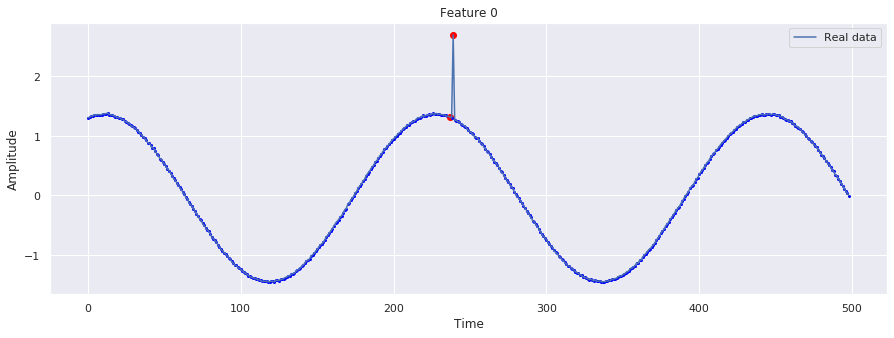

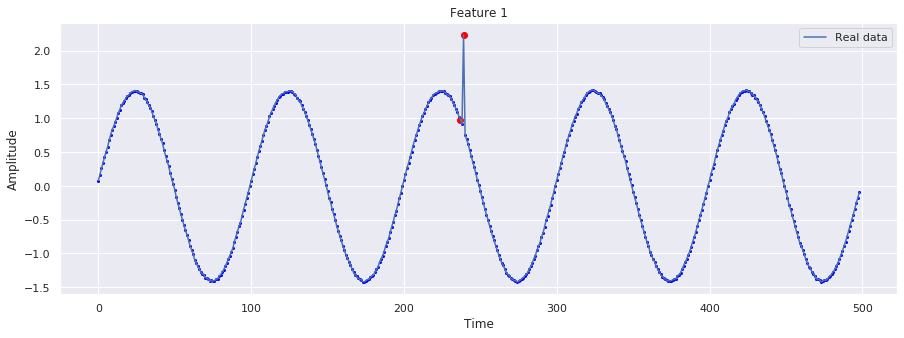

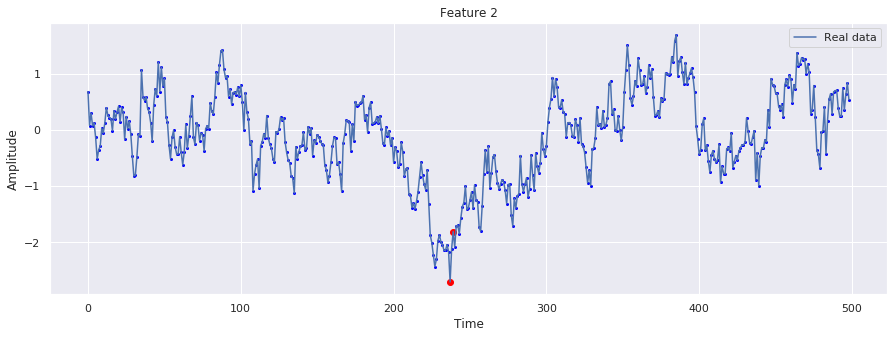

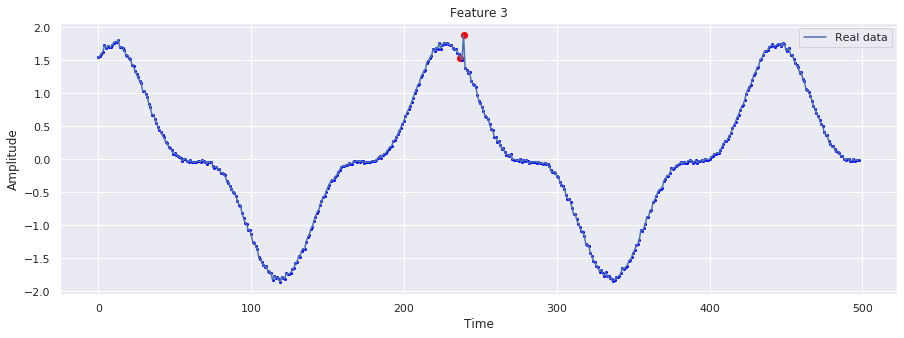

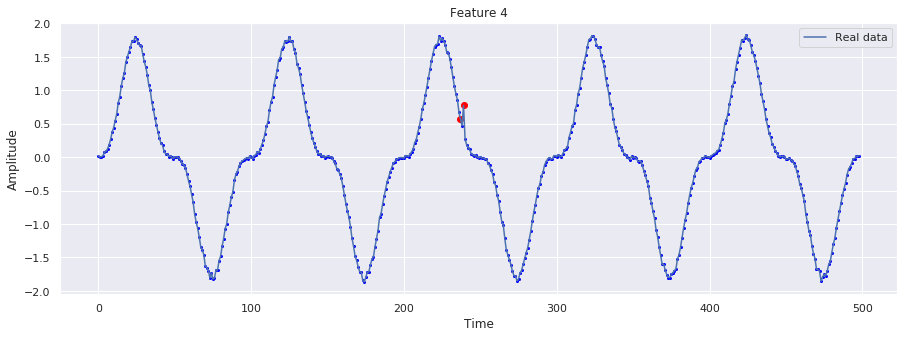

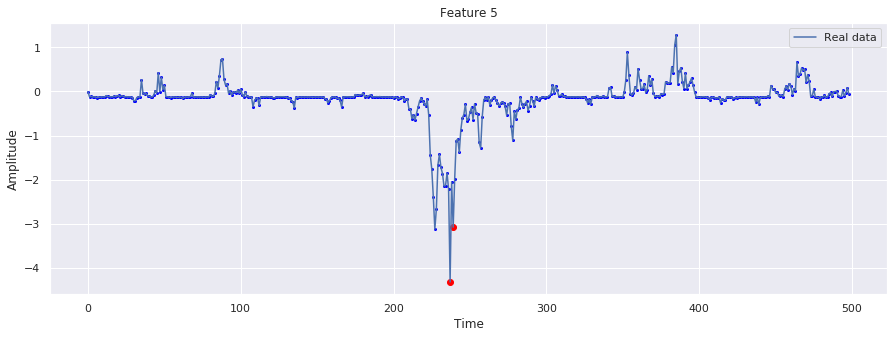

In [79]:
sequence = valid_dataset.get_data()[0]
sequence = test_dataset.get_data()[0]

percentage = 0.00001
anomaly_data = detect_anomalies_VAE(sequence, net, device, percentage/100)
anomalies_figs_VAE = plot_anomalies(anomaly_data, sequence, 0, 1000)

In [80]:
predictions = anomaly_data["outlier_label"]
ground_truth = valid_dataset.get_data()[1]
ground_truth = test_dataset.get_data()[1]
correct = 0
total = len(predictions) - 1
false_positives = 0
false_negatives = 0
anomaly_count = 0
for i in range(total):
    if ground_truth[i] == True:
        anomaly_count += 1
    if predictions[i] == ground_truth[i]:
        correct += 1
    elif predictions[i] == False:
        false_negatives += 1
    elif predictions[i] == True:
        false_positives += 1
accuracy_VAE = {
    # number of labels correctly predicted
    "correct": correct,  
    # false positives (the datapoint was not an anomaly but it was predicted as one)
    "false_positives": false_positives,
    # false negatives (the datapoint was an anomaly abut it was not predicted as one)
    "false_negatives": false_negatives,
    # total number of datapoints in the sequence
    "total": total,
    # total number of anomalies
    "anomaly_count": anomaly_count
}
print(accuracy_VAE)

{'correct': 498, 'false_positives': 1, 'false_negatives': 0, 'total': 499, 'anomaly_count': 1}
